# ATLAS OmniFold - Technical Closure
In this notebook, we use a single a sample to perform a technical closure test (unfolding the sample against itself).

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from __future__ import absolute_import, division, print_function

from ntupleanalysis import *
import math

import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import energyflow as ef
from energyflow.archs import PFN

/global/home/users/adisurtya/anaconda3/envs/omnifold_gpu/lib/python3.7/site-packages/energyflow/emd.py:915: UserWarning: emd module requires 'wasserstein' or 'pot', both of which are unavailable
  warnings.warn(message)


In [4]:
plot_setup()

In [5]:
# Global plot settings
import matplotlib.font_manager
plt.rcParams.update({
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.size": 22,
    "xtick.labelsize": 15, 
    "ytick.labelsize": 15, 
    "legend.fontsize":15
})

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled', 'alpha': 0.5, 'density': True}

### Utilities

In [7]:
# from NN (DCTR)
def reweight(model, events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

In [8]:
# Binary crossentropy for classifying two samples with weights
# Weights are "hidden" by zipping in y_true (the labels)


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1)  # event weights
    y_true = tf.gather(y_true, [0], axis=1)  # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [9]:
# z-score standardization of data


def standardize(sim_truth, sim_reco, data_reco):
    scaler_truth = preprocessing.StandardScaler()
    scaler_reco = preprocessing.StandardScaler()

    scaler_truth.fit(sim_truth.reshape(-1, 1))
    scaler_reco.fit(np.concatenate((sim_reco, data_reco)).reshape(-1, 1))

    sim_truth_z = np.squeeze(scaler_truth.transform(sim_truth.reshape(-1, 1)))
    sim_reco_z = np.squeeze(scaler_reco.transform(sim_reco.reshape(-1, 1)))
    data_reco_z = np.squeeze(scaler_reco.transform(data_reco.reshape(-1, 1)))

    return sim_truth_z, sim_reco_z, data_reco_z

In [10]:
plot_dir = './SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-TechnicalClosureTest/'

In [11]:
save_label0 = 'ATLASOmniFold-TechnicalClosureTest'

### Load ROOT files

In [12]:
data_dir = '/clusterfs/ml4hep/bpnachman/OmniFoldATLAS/SlimFeb27/'

In [13]:
zmumu = uproot.open(
    data_dir + "ZjetOmnifold_Feb20_PowhegPythia_mc16e_slim.root")['OmniTree']

In [14]:
zmumu.show()

weight                     (no streamer)              asdtype('>f4')
pass190                    (no streamer)              asdtype('>i4')
truth_pass190              (no streamer)              asdtype('>i4')
weight_mc                  (no streamer)              asdtype('>f4')
prw                        (no streamer)              asdtype('>f4')
pT_ll                      (no streamer)              asdtype('>f4')
pT_l1                      (no streamer)              asdtype('>f4')
pT_l2                      (no streamer)              asdtype('>f4')
eta_l1                     (no streamer)              asdtype('>f4')
eta_l2                     (no streamer)              asdtype('>f4')
phi_l1                     (no streamer)              asdtype('>f4')
phi_l2                     (no streamer)              asdtype('>f4')
y_ll                       (no streamer)              asdtype('>f4')
pT_trackj1                 (no streamer)              asdtype('>f4')
y_trackj1                  (no str

In [15]:
mybranches = []
for mykey in zmumu.keys():
    mybranches += [mykey.decode("utf-8")]

In [16]:
Events = prepare_dataset_table(
    [data_dir + "ZjetOmnifold_Feb20_PowhegPythia_mc16e_slim.root"],
    "OmniTree",
    branch_list=mybranches,
    col_names=mybranches,
    entrysteps=10000000,
    outputype=Event_table)

Total number of events:  416725
Events in returned Object:  416725
Loading the data took  8.237359046936035  seconds


### Unpack data

In [17]:
# Event selection

# we should eventually properly account for events that fail one of MC Truth or MC Reco - for now, just ignore them.

mypass = (Events.events['pass190'].astype(bool)
            ) & Events.events['truth_pass190'].astype(bool) & (np.abs(
                Events.events['truth_y_trackj1']) < 2.1) & (np.abs(
                    Events.events['y_trackj1']) < 2.1) & (np.abs(
                        Events.events['truth_y_trackj2']) < 2.1) & (np.abs(
                            Events.events['y_trackj2']) < 2.1) & (
                                Events.events['m_trackj1'] !=
                                -99) & (Events.events['m_trackj2'] != -99)

In [18]:
# Load Monte Carlo Event Weights
weights_MC = Events.events['weight'][mypass]

# standardize
weights_MC = weights_MC / np.mean(weights_MC)

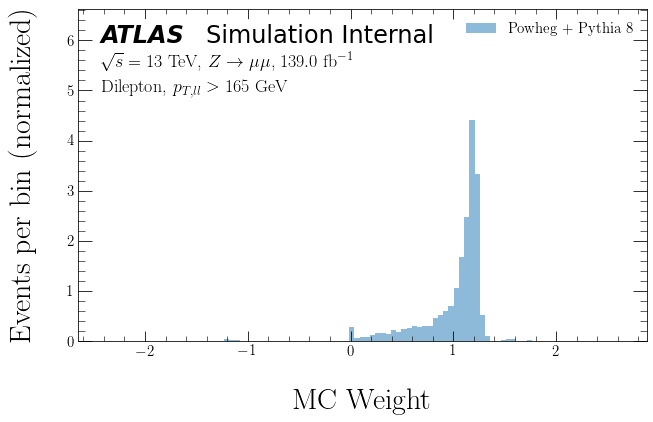

In [19]:
plt.figure(figsize=(10, 6))
bins = np.linspace(np.min(weights_MC), np.max(weights_MC), 100)

hW, _, _ = plt.hist(weights_MC, bins=bins, label=r'Powheg + Pythia 8', **plot_style_2)
plt.xlabel('MC Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top = 1.5*np.max(hW))
plt.legend()
draw_atlas_text()
plt.show()

In [20]:
file_labels = [
    'm_trackj1', 'm_trackj2', 'Ntracks_trackj1', 'Ntracks_trackj2',
    'tau1_trackj1', 'tau1_trackj2', 'pT_trackj1', 'pT_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'y_trackj1', 'y_trackj2', 'tau3_trackj1', 'tau3_trackj2',
    'pT_ll', 'y_ll'
]

plot_labels = [
    '$m_{j_1}$ [GeV]', '$m_{j_2}$ [GeV]', '$N_{j_1}$', '$N_{j_2}$',
    '$\tau_{1,j_1}$', '$\tau_{1,j_2}$', '$p_{T,j_1}$ [GeV]',
    '$p_{T,j_2}$ [GeV]', '$\tau_{2,j_1}$', '$\tau_{2,j_2}$', '$y_{j_1}$',
    '$y_{j_2}$', '$\tau_{3,j_1}$', '$\tau_{3,j_2}$', '$p_{T,ll}$ [GeV]',
    '$y_{ll}$'
]

bins = [
    np.linspace(0, 50, 21),
    np.linspace(0, 25, 21),
    np.linspace(0, 40, 21),
    np.linspace(0, 40, 21),
    np.linspace(0, 1, 21),
    np.linspace(0, 1, 21),
    np.linspace(0, 500, 21),
    np.linspace(0, 200, 21),
    np.linspace(0, 0.5, 21),
    np.linspace(0, 0.5, 21),
    np.linspace(-4, 4, 21),
    np.linspace(-7.5, 7.5, 21),
    np.linspace(0, 0.4, 21),
    np.linspace(0, 0.4, 21),
    np.linspace(190, 590, 21),
    np.linspace(-3, 3, 21)
]

In [21]:
labels_and_bins = zip(file_labels, plot_labels, bins)

obs = []

for file_label, plot_label, plot_bins in labels_and_bins:
    obs += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]

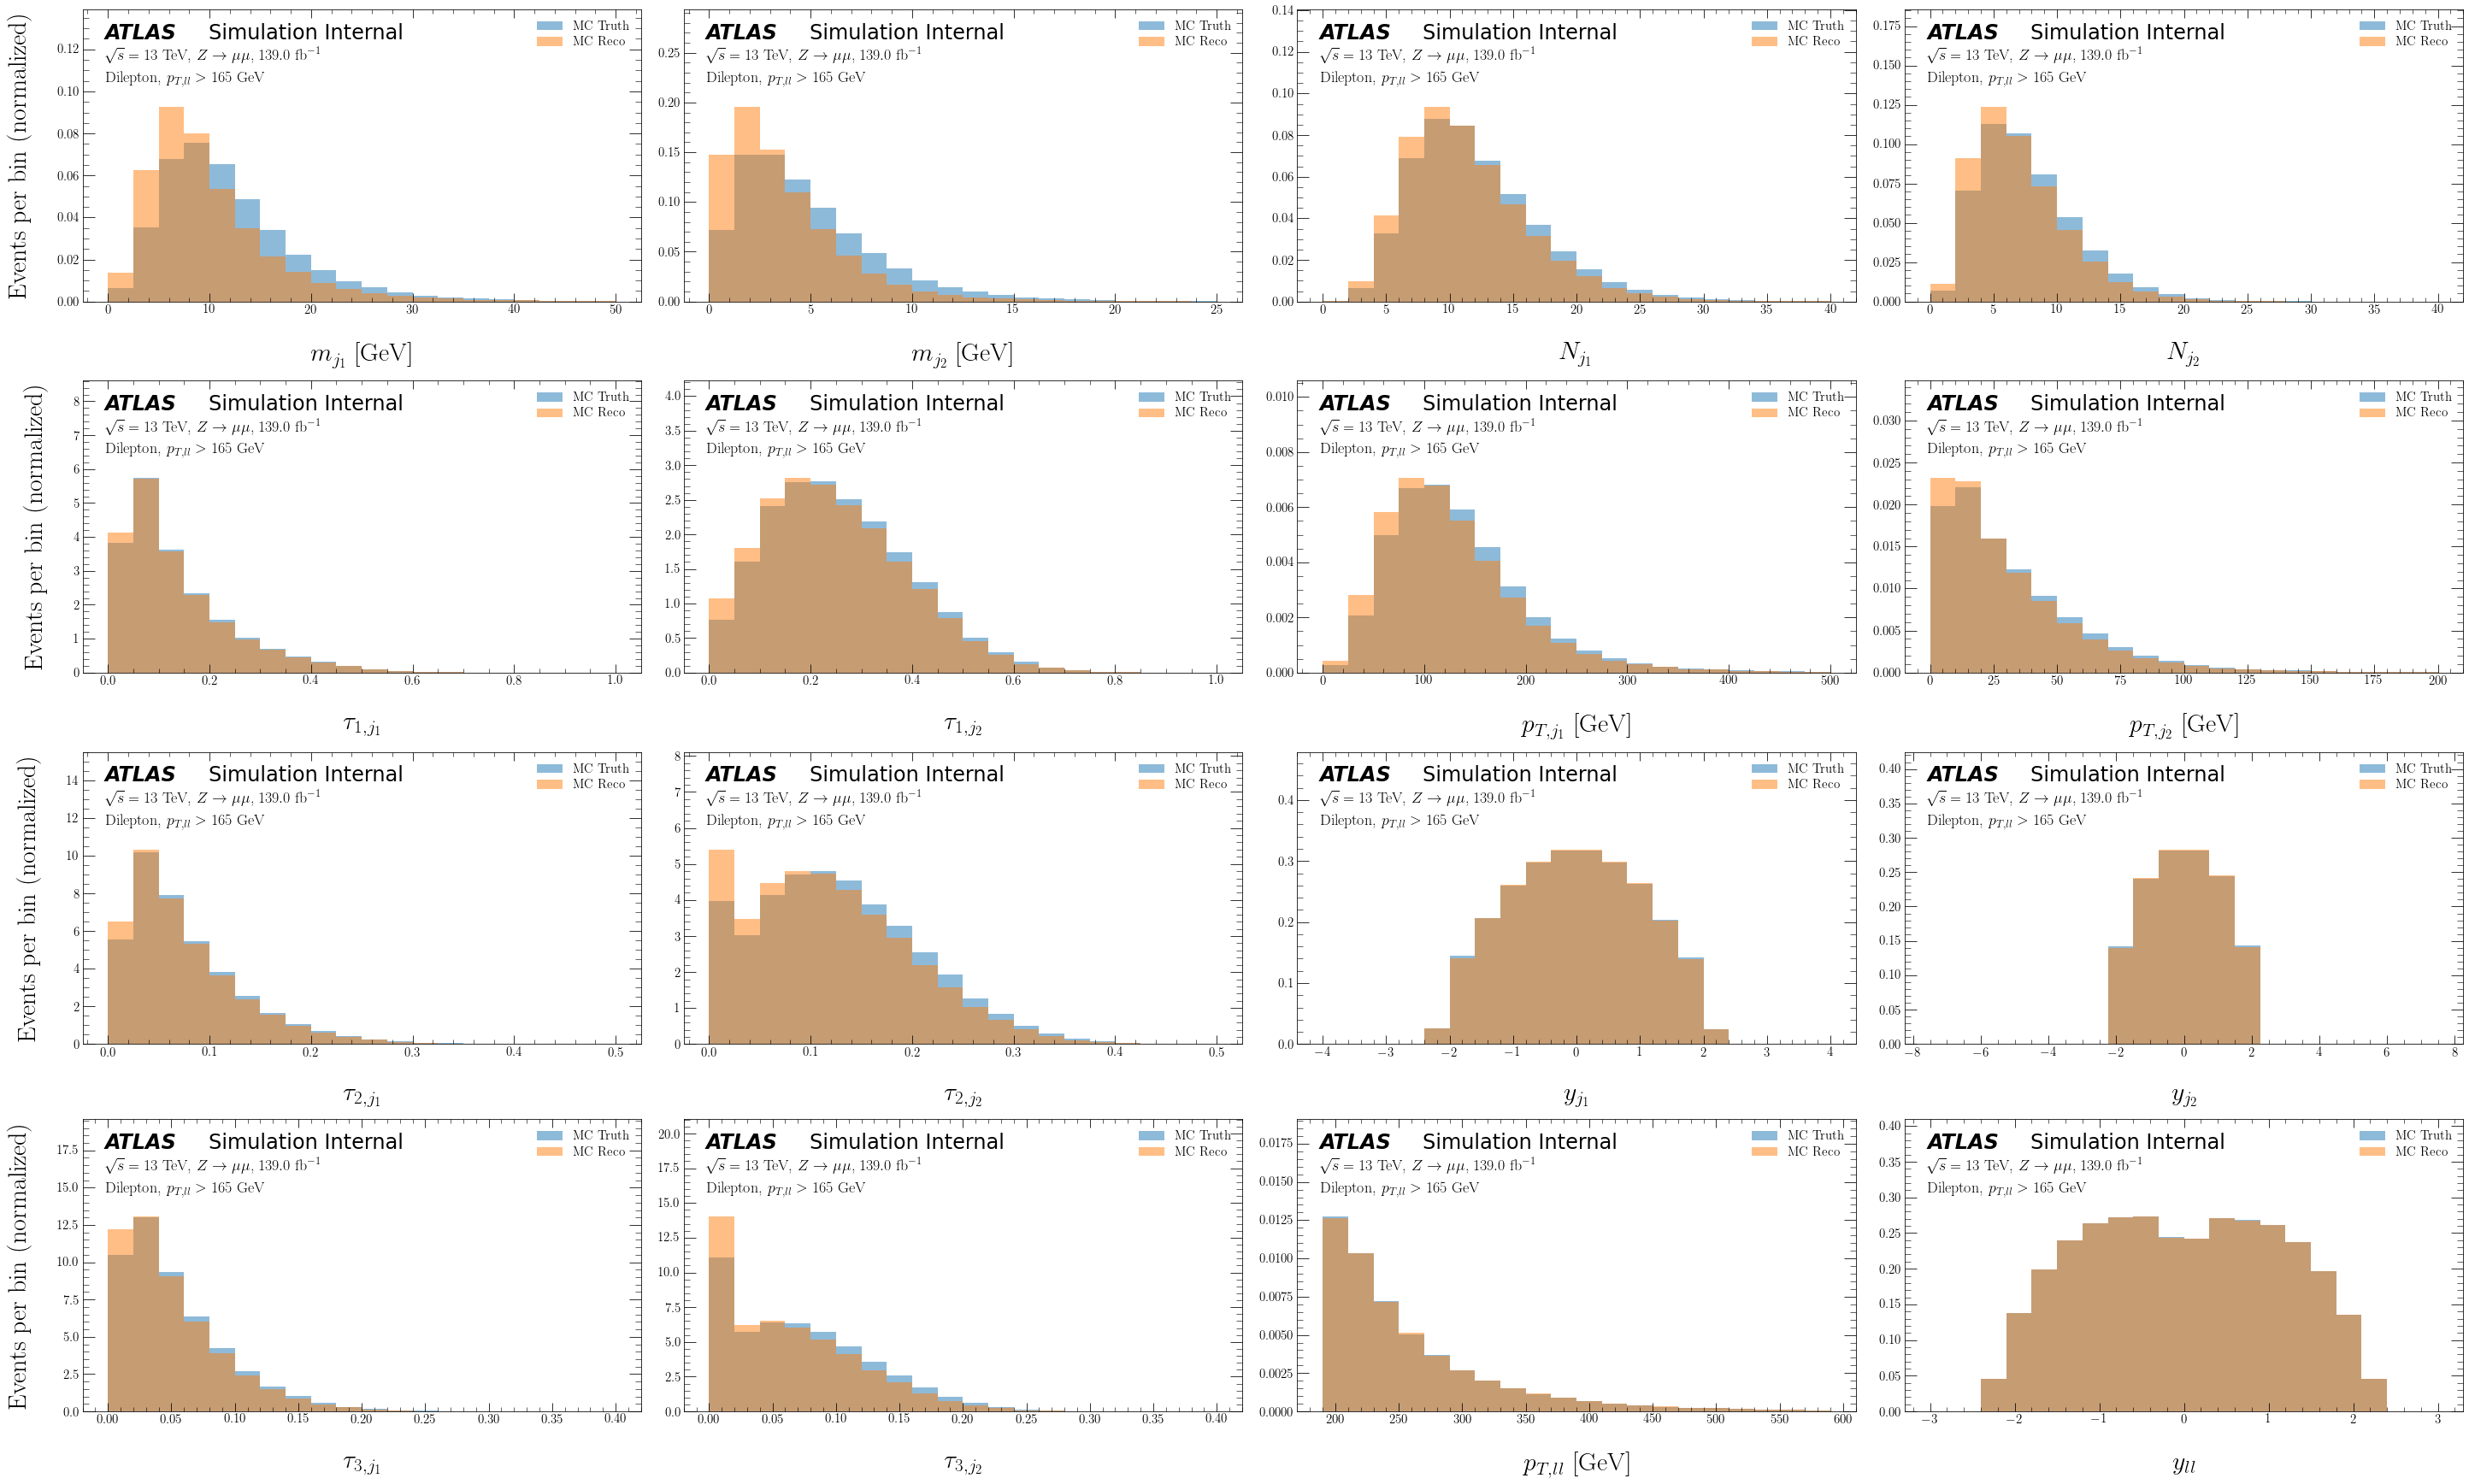

In [22]:
# Preview Observables

fig, ax = plt.subplots(4, 4, figsize=(40, 24), constrained_layout=True)
ax = np.ndarray.flatten(ax)

for i in range(len(obs)):
    bins = obs[i]['bins']
    hT, _, _ = ax[i].hist(Events.events['truth_' +
                                          obs[i]['file_label']][mypass],
                          weights=weights_MC,
                          bins=bins,
                          label="MC Truth", **plot_style_2)
    hR, _, _ = ax[i].hist(Events.events[obs[i]['file_label']][mypass],
                          weights=weights_MC,
                          bins=bins,
                          label="MC Reco", **plot_style_2)
    ax[i].set_xlabel(obs[i]['plot_label'].encode('unicode-escape').decode())
    draw_atlas_text(ax=ax[i])
    if i % 4 == 0:
        ax[i].set_ylabel("Events per bin (normalized)")
    ax[i].legend()
    ax[i].set_ylim([0, 1.5 * max(max(hT), max(hR))])

### Define UniFold Algorithm

In [23]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        sim_truth: MC Truth observable as Numpy array
                    
        sim_reco: MC Reco observable as Numpy array
                    
        data_reco: Data Reco observable 
                            to be unfolded as Numpy arrays
                            
        sim_weights_MC: (optional) initial MC generator weights for simulation sample
        
        data_weights_MC: (optional) initial MC generator weights for "data" sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""


def unifold(iterations,
            sim_truth,
            sim_reco,
            data_reco,
            sim_weights_MC=None,
            data_weights_MC=None):

    if sim_weights_MC is None:
        sim_weights_MC = np.ones(len(sim_truth))

    if data_weights_MC is None:
        data_weights_MC = np.ones(len(data_reco))

    labels_sim = np.zeros(len(sim_reco))
    labels_data = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    yvals_1 = np.concatenate((labels_sim, labels_data))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    yvals_2 = np.concatenate((labels_sim, (labels_sim + 1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = sim_weights_MC
    weights_push = sim_weights_MC

    inputs = Input((1, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, data_weights_MC))
        # iterative weights for MC Reco, initial weights for Data Reco

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights_pull[np.argwhere(
            np.isinf(weights_pull))] = sim_weights_MC[np.argwhere(
                np.isinf(weights_pull))]
        weights[i, :1, :] = weights_pull

        # STEP 2: classify nominal MC Truth to reweighted (by weights_pull) MC Truth
        # weights nominal MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((sim_weights_MC, weights_pull))
        # initial weights for MC Truth, iterative weights for (reweighted) MC Truth

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = sim_weights_MC * reweight(model, sim_truth)
        weights_push[np.argwhere(
            np.isinf(weights_push))] = sim_weights_MC[np.argwhere(
                np.isinf(weights_push))]
        weights[i, 1:2, :] = weights_push

    return weights, model

### Define MultiFold Algorithm

In [24]:
# Input multiple observables as tuple or list (i.e. sim_truth = (obs_1, obs_2, ...))
"""    Arguments:

        iterations: number of iterations (integer)
        
        sim_truth: tuple or list of MC Truth 
                    observables as Numpy arrays
                    
        sim_reco: tuple or list of MC Reco 
                    observables as Numpy arrays
                    
        data_reco: tuple or list of Data Reco 
                    observables to be unfolded 
                    as Numpy arrays
        
        sim_weights_MC: (optional) initial MC generator weights for simulation sample
        
        data_weights_MC: (optional) initial MC generator weights for "data" sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""


def multifold(iterations,
              sim_truth,
              sim_reco,
              data_reco,
              sim_weights_MC=None,
              data_weights_MC=None):

    num_observables = len(sim_truth)

    sim_truth = np.stack(sim_truth, axis=1)
    sim_reco = np.stack(sim_reco, axis=1)
    data_reco = np.stack(data_reco, axis=1)

    if sim_weights_MC is None:
        sim_weights_MC = np.ones(len(sim_truth))

    if data_weights_MC is None:
        data_weights_MC = np.ones(len(data_reco))

    labels_0 = np.zeros(len(sim_truth))
    labels_unknown = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    yvals_2 = np.concatenate((labels_0, (labels_0 + 1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = sim_weights_MC
    weights_push = sim_weights_MC

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, data_weights_MC))
        # actual weights for MC Reco, ones for Data Reco

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights_pull[np.argwhere(
            np.isinf(weights_pull))] = sim_weights_MC[np.argwhere(
                np.isinf(weights_pull))]
        weights[i, :1, :] = weights_pull

        # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
        # weights MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((sim_weights_MC, weights_pull))
        # ones for MC Truth, actual weights for (reweighted) MC Truth

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = sim_weights_MC * reweight(model, sim_truth)
        weights_push[np.argwhere(
            np.isinf(weights_push))] = sim_weights_MC[np.argwhere(
                np.isinf(weights_push))]
        weights[i, 1:2, :] = weights_push

    return weights, model

### Define OmniFold Algorithm

In [25]:
"""    Arguments:
                            
        iterations: number of iterations (integer)
        
        sim_truth: MC Truth events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        sim_truth: MC Reco events 
                    (i.e. list of events with particles as 
                    (pT, eta, phi, charge)) as zero-padded Numpy array
                    
        data_reco: Data Reco events 
                            (i.e. list of events with particles as 
                            (pT, eta, phi, charge))
                            to be unfolded as zero-padded Numpy array 
                            
        
        sim_weights_MC: (optional) initial MC generator weights for simulation sample
        
        data_weights_MC: (optional) initial MC generator weights for data sample
        
        Returns:
        
        weights: A Numpy array of weights to reweight distribution of 
                    sim_truth to the unfolded distribution of data_reco
        
        model: The model used to calculate those weights
"""


def omnifold(iterations,
             sim_truth,
             sim_reco,
             data_reco,
             sim_weights_MC=None,
             data_weights_MC=None):

    if sim_weights_MC is None:
        sim_weights_MC = np.ones(len(sim_truth))

    if data_weights_MC is None:
        data_weights_MC = np.ones(len(data_reco))

    labels_0 = np.zeros(len(sim_truth))
    labels_unknown = np.ones(len(data_reco))

    xvals_1 = np.concatenate((sim_reco, data_reco))
    yvals_1 = np.concatenate((labels_0, labels_unknown))

    xvals_2 = np.concatenate((sim_truth, sim_truth))
    yvals_2 = np.concatenate((labels_0, (labels_0 + 1.)))

    weights = np.empty(shape=(iterations, 2, len(sim_truth)))
    # shape = (iteration, step, event)

    weights_pull = sim_weights_MC
    weights_push = sim_weights_MC

    # network architecture parameters
    Phi_sizes = (100, 100, 128)
    F_sizes = (100, 100, 100)

    model = PFN(input_dim=4,
                Phi_sizes=Phi_sizes,
                F_sizes=F_sizes,
                latent_dropout=0.2,
                F_dropouts=0.2,
                output_dim=1,
                output_act='sigmoid',
                summary=False)

    earlystopping = EarlyStopping(patience=5, restore_best_weights=True)

    print("Jumpstarting Model\n")
    count = 0
    while count < 20:
        count += 1

        X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(
            xvals_1, yvals_1)

        model.model.compile(loss='binary_crossentropy',
                            optimizer=keras.optimizers.Adam(),
                            metrics=['accuracy'])
        history = model.fit(X_train_1,
                            Y_train_1,
                            epochs=1,
                            batch_size=10000,
                            validation_data=(X_test_1, Y_test_1),
                            verbose=1)
        if (history.history['val_loss'][0] < history.history['loss'][0] -
                0.1) or history.history['val_loss'][0] < 1:
            break
        else:
            K.clear_session()

            model = PFN(input_dim=4,
                        Phi_sizes=Phi_sizes,
                        F_sizes=F_sizes,
                        latent_dropout=0.2,
                        F_dropouts=0.2,
                        output_dim=1,
                        output_act='sigmoid',
                        summary=False)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify MC Reco (which is reweighted by weights_push) to Data Reco
        # weights reweighted MC Reco --> Data Reco
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, data_weights_MC))
        # actual weights for MC Reco, initial MC for Data Reco

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

        model.model.compile(loss=weighted_binary_crossentropy,
                            optimizer='Adam',
                            metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(model, sim_reco)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
        # weights MC Truth --> reweighted MC Truth
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((sim_weights_MC, weights_pull))
        # initial MC for MC Truth, actual weights for (reweighted) MC Truth

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        model.model.compile(loss=weighted_binary_crossentropy,
                            optimizer='Adam',
                            metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  epochs=200,
                  batch_size=1000,
                  validation_data=(X_test_2, Y_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = sim_weights_MC * reweight(model, sim_truth)
        weights[i, 1:2, :] = weights_push

    return weights, model

### Plotting

In [26]:
def plot_distributions(sim_truth,
                       sim_reco,
                       data_reco,
                       bins,
                       x_label,
                       data_weights_MC=None,
                       sim_weights_MC=None,
                       data_truth=None,
                       save_label=None):

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(20, 6),
                           constrained_layout=True,
                           sharey=True)

    hT0, _, _ = ax[0].hist(sim_truth,
                           weights=sim_weights_MC,
                           bins=bins,
                           label='MC Truth',
                           **plot_style_2,
                           color='C0')
    hR0, _, _ = ax[0].hist(sim_reco,
                           weights=sim_weights_MC,
                           bins=bins,
                           label='MC Reco',
                           **plot_style_2,
                           color='C1')
    ax[0].set_xlabel(x_label.encode('unicode-escape').decode())
    ax[0].set_ylabel('Events per bin (normalized)')
    legend = ax[0].legend(title='Simulation', loc='upper right', frameon=False)
    plt.setp(legend.get_title(), multialignment='center')
    ax[0].set_ylim([0, 1.5 * max(max(hT0), max(hR0))])
    draw_atlas_text(ax=ax[0])

    hT1, _, _ = ax[1].hist(data_truth,
                           weights=data_weights_MC,
                           bins=bins,
                           label='"Data" Truth',
                           **plot_style_2,
                           color='C2')
    hR1, _, _ = ax[1].hist(data_reco,
                           weights=data_weights_MC,
                           bins=bins,
                           label='"Data" Reco',
                           **plot_style_2,
                           color='k')
    ax[1].set_xlabel(x_label.encode('unicode-escape').decode())
    ax[1].set_ylim([0, 1.5 * max(max(hT1), max(hR1))])
    legend = ax[1].legend(title='"Data"', loc='upper right', frameon=False)
    plt.setp(legend.get_title(), multialignment='center')
    draw_atlas_text(ax=ax[1])
    if save_label is not None:
        fig.savefig(save_label + '-Distributions.pdf',
                    bbox_inches='tight',
                    backend='pgf')
    fig.show()

In [27]:
def plot_results(sim_truth,
                 sim_reco,
                 data_reco,
                 weights,
                 bins,
                 x_label,
                 data_weights_MC=None,
                 sim_weights_MC=None,
                 data_truth=None,
                 save_label=None):

    if sim_weights_MC is None:
        sim_weights_MC = np.ones(len(sim_reco))
    if data_weights_MC is None:
        data_weights_MC = np.ones(len(data_reco))

    for i in range(len(weights)):
        print("ITERATION {}:".format(i + 1))

        fig, ax = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)

        if i == 0:
            weights_init = sim_weights_MC
            label0 = ''
            label1 = ', iter-{}'.format(i + 1)
        else:
            weights_init = weights[i - 1, 1, :]
            label0 = ', iter-{}'.format(i)
            label1 = ', iter-{}'.format(i + 1)

        hR0, _, _ = ax[0].hist(sim_reco,
                               weights=weights_init,
                               bins=bins,
                               label='MC Reco' + label0 + '\n' +
                               r'(wgt.$=\nu_{{{}}}$)'.format(i),
                               **plot_style_2,
                               color='C1')

        hR1, _, _ = ax[0].hist(sim_reco,
                               weights=weights[i, 0, :],
                               bins=bins,
                               label='MC Reco' + label1 + '\n' +
                               r'(wgt.$=\omega_{{{}}}$)'.format(i + 1),
                               **plot_style_1)
        hR2, _, _ = ax[0].hist(data_reco,
                               weights=data_weights_MC,
                               bins=bins,
                               label='"Data" Reco (Target)',
                               **plot_style_2,
                               color='k')
        ax[0].set_xlabel(x_label.encode('unicode-escape').decode())
        ax[0].set_ylabel("Events per bin (normalized)")
        ax[0].set_ylim([0, 1.5 * np.max(np.concatenate((hR0, hR1, hR2)))])
        draw_atlas_text(ax=ax[0])
        ax[0].legend()
        hT0, _, _ = ax[1].hist(sim_truth,
                               weights=sim_weights_MC,
                               bins=bins,
                               label=r'MC Truth',
                               **plot_style_2)

        hT1, _, _ = ax[1].hist(sim_truth,
                               weights=weights[i, 1, :],
                               bins=bins,
                               label='OmniFolded "Data"' + label1 + '\n' +
                               r'(wgt.$=\nu_{}$)'.format(i + 1),
                               **plot_style_1)
        if data_truth is not None:
            hT2, _, _ = ax[1].hist(data_truth,
                                   weights=data_weights_MC,
                                   bins=bins,
                                   label='"Data" Truth (Target)',
                                   **plot_style_2,
                                   color='C2')
        ax[1].legend()
        ax[1].set_xlabel(x_label.encode('unicode-escape').decode())
        ax[1].set_ylim([0, 1.5 * np.max(np.concatenate((hT0, hT1, hT2)))])
        draw_atlas_text(ax=ax[1])
        fig.show()
        if save_label is not None:
            fig.savefig(save_label + '-Iteration{:02}.pdf'.format(i + 1),
                        bbox_inches='tight',
                        backend='pgf')
        plt.show()

# UniFold

To show unfolding of individual observables ("UniFold"), we will unfold the following observables for the leading track jet: the jet mass $m_{j_1}$, the number of constituents (tracks) $N_{j_1}$, the transverse momentum $p_{T,j_1}$, the rapidity $y_{j_1}$, and the $n$-subjettiness $\tau_{1, j_1}$.

## Unfold $m_{j_1}$

In [28]:
K.clear_session()

In [29]:
obs_index = 0 # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [30]:
sim_truth, data_truth, sim_reco, data_reco, sim_weights_MC, data_weights_MC = train_test_split(
    Events.events['truth_' + file_label][mypass],
    Events.events[file_label][mypass],
    weights_MC,
    test_size=0.5)

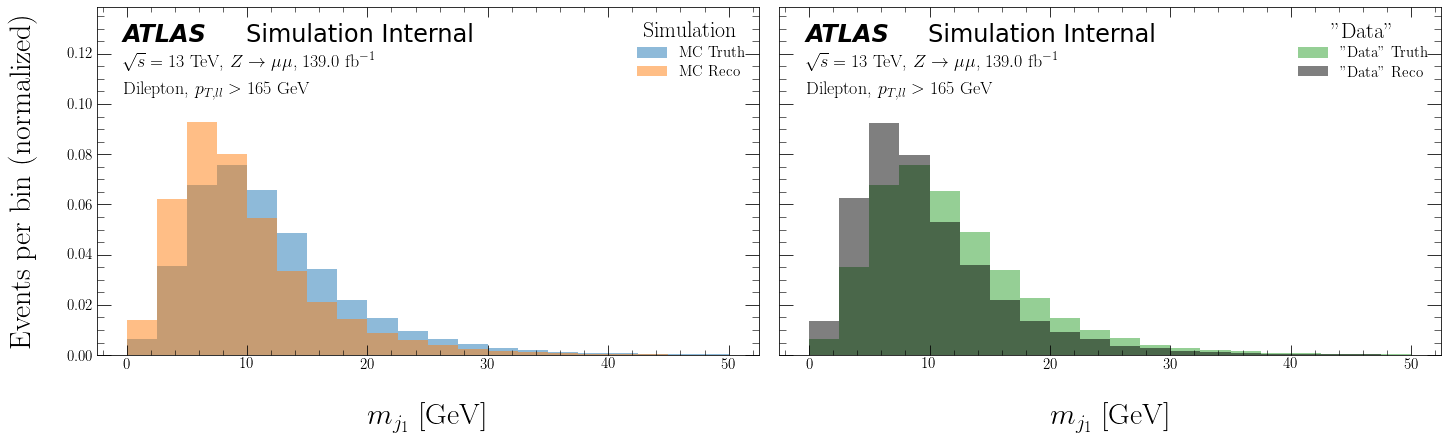

In [31]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_weights_MC=sim_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_weights_MC=data_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [32]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [33]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_weights_MC=sim_weights_MC,
                     data_reco=data_reco_z,
                     data_weights_MC=data_weights_MC)


ITERATION: 1

STEP 1

Epoch 1/200
16/16 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.2525 - val_loss: 0.6941 - val_accuracy: 0.2544
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.2517 - val_loss: 0.6941 - val_accuracy: 0.2525
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.2535 - val_loss: 0.6941 - val_accuracy: 0.2545
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.2539 - val_loss: 0.6941 - val_accuracy: 0.2530
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.2535 - val_loss: 0.6941 - val_accuracy: 0.2525
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.2526 - val_loss: 0.6941 - val_accuracy: 0.2538
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.2544 - val_loss: 0.6941 - val_accura

16/16 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.2535 - val_loss: 0.6921 - val_accuracy: 0.2529
Epoch 32/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.2522 - val_loss: 0.6921 - val_accuracy: 0.2515
Epoch 33/200
16/16 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.2521 - val_loss: 0.6922 - val_accuracy: 0.2534
Epoch 00033: early stopping

STEP 2

Epoch 1/200
16/16 [==============================] - 0s 8ms/step - loss: 0.6933 - accuracy: 0.2525 - val_loss: 0.6937 - val_accuracy: 0.2502
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.2507 - val_loss: 0.6936 - val_accuracy: 0.2503
Epoch 3/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.2513 - val_loss: 0.6936 - val_accuracy: 0.2521
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.2519 - val_loss: 0.6936 - val_acc

#### Results

ITERATION 1:


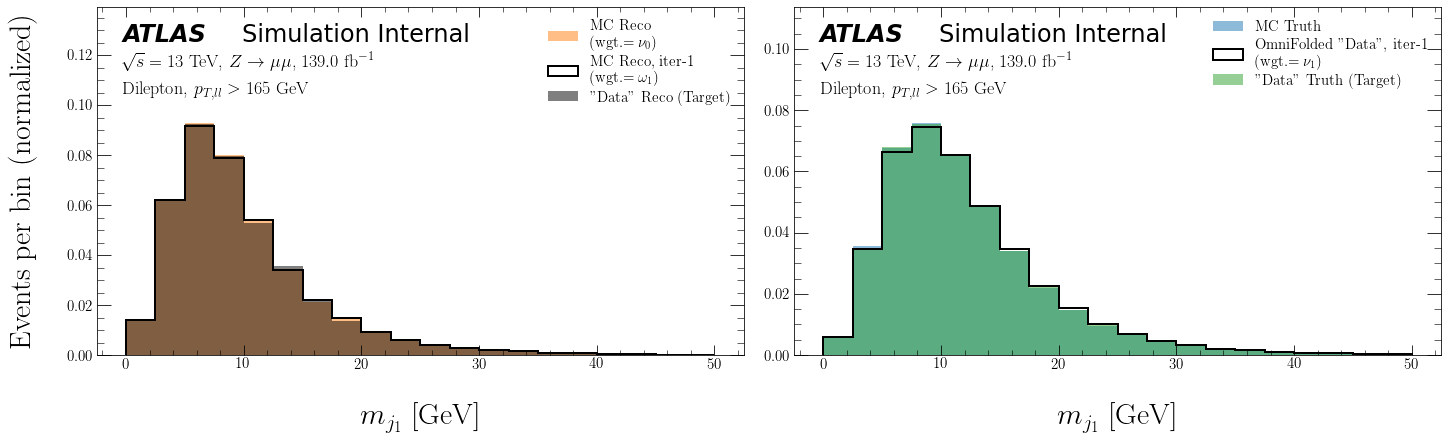

ITERATION 2:


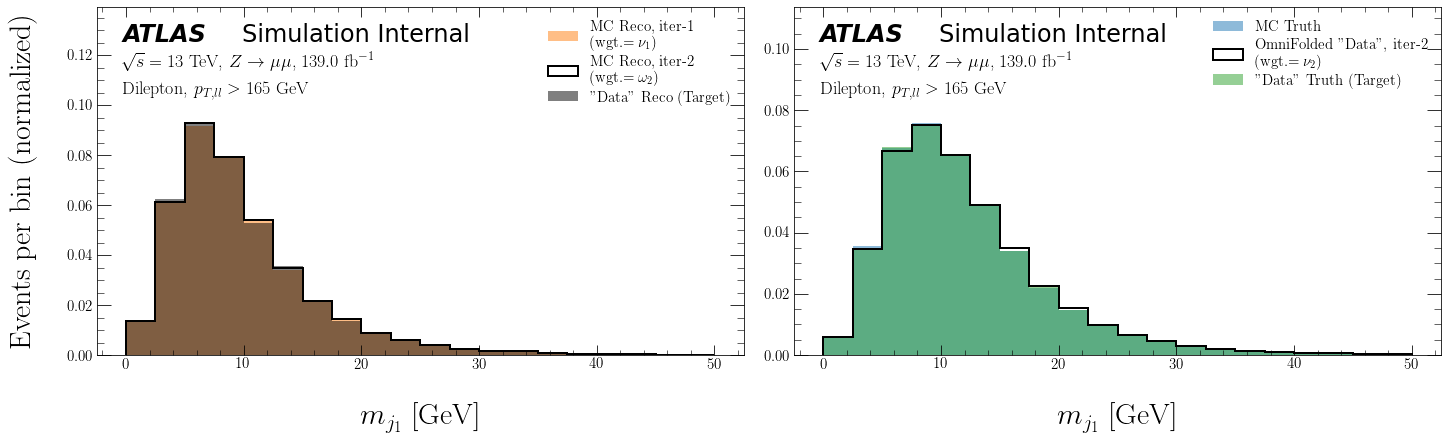

ITERATION 3:


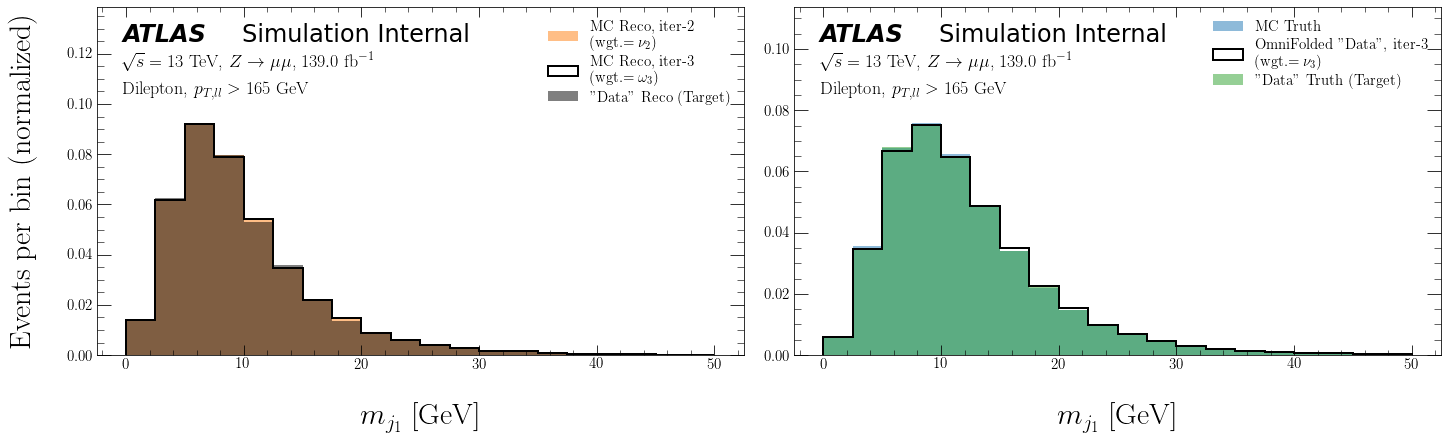

In [34]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_weights_MC=sim_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_weights_MC=data_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             save_label=save_label)

## Unfold $N_{j_1}$

In [35]:
K.clear_session()

In [36]:
obs_index = 2  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [37]:
sim_truth, data_truth, sim_reco, data_reco, sim_weights_MC, data_weights_MC = train_test_split(
    Events.events['truth_' + file_label][mypass],
    Events.events[file_label][mypass],
    weights_MC,
    test_size=0.5)

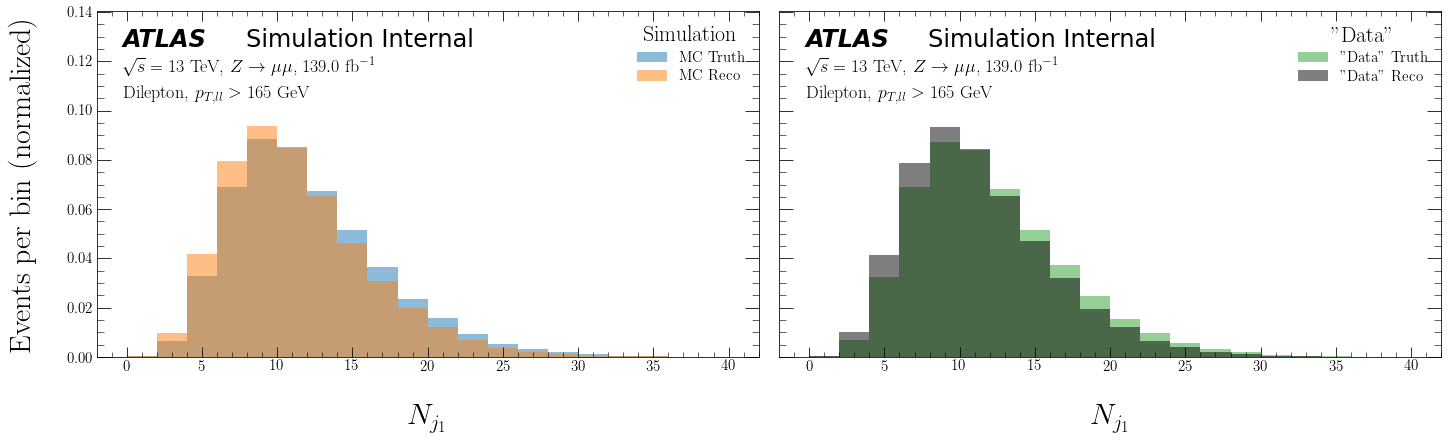

In [38]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_weights_MC=sim_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_weights_MC=data_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [39]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [40]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_weights_MC=sim_weights_MC,
                     data_reco=data_reco_z,
                     data_weights_MC=data_weights_MC)


ITERATION: 1

STEP 1

Epoch 1/200
16/16 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.2530 - val_loss: 0.6936 - val_accuracy: 0.2534
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.2523 - val_loss: 0.6936 - val_accuracy: 0.2519
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.2531 - val_loss: 0.6935 - val_accuracy: 0.2518
Epoch 4/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.2537 - val_loss: 0.6937 - val_accuracy: 0.2496
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.2516 - val_loss: 0.6935 - val_accuracy: 0.2518
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.2522 - val_loss: 0.6935 - val_accuracy: 0.2534
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.2530 - val_loss: 0.6936 - val_accurac

16/16 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.2510 - val_loss: 0.6936 - val_accuracy: 0.2514
Epoch 12/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.2542 - val_loss: 0.6936 - val_accuracy: 0.2513
Epoch 13/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.2525 - val_loss: 0.6936 - val_accuracy: 0.2519
Epoch 14/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.2538 - val_loss: 0.6936 - val_accuracy: 0.2518
Epoch 15/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.2541 - val_loss: 0.6936 - val_accuracy: 0.2516
Epoch 16/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.2522 - val_loss: 0.6936 - val_accuracy: 0.2509
Epoch 00016: early stopping

STEP 2

Epoch 1/200
16/16 [==============================] - 0s 8ms/step - loss: 0.6927 - accuracy: 0.2524 - val_loss: 0.6932 - val_

#### Results

ITERATION 1:


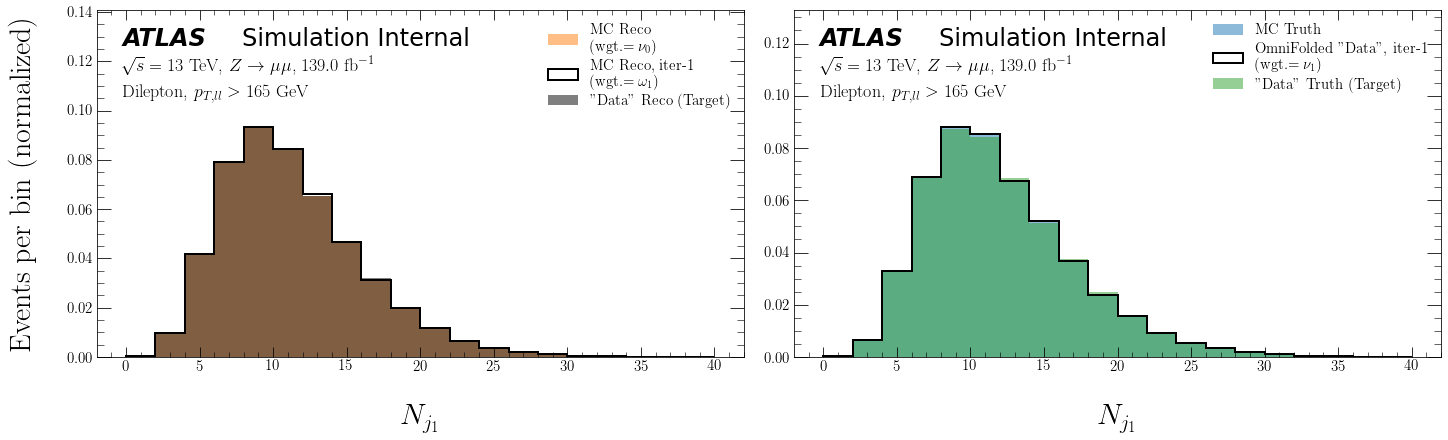

ITERATION 2:


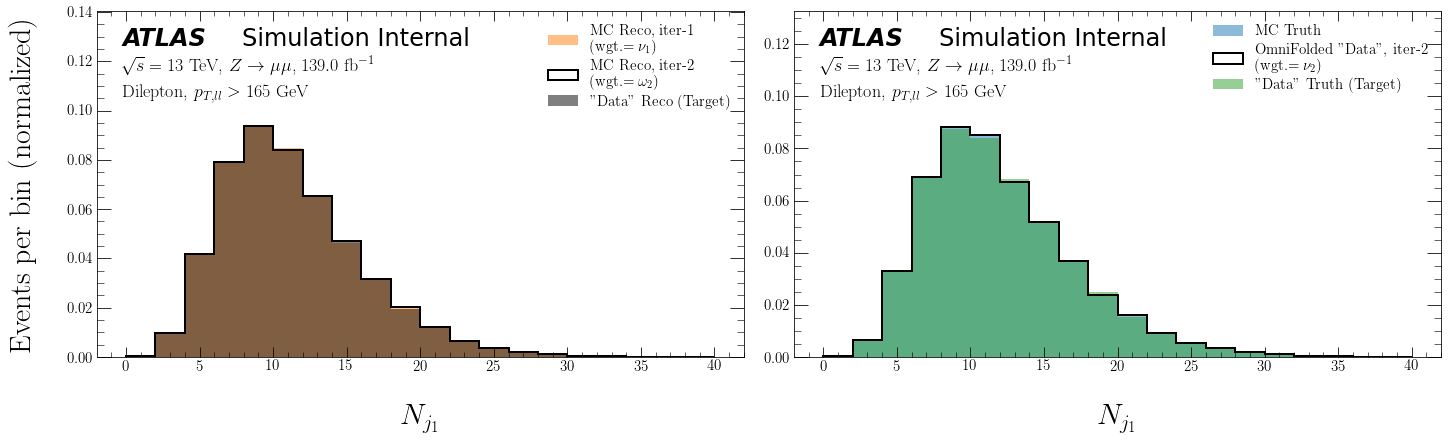

ITERATION 3:


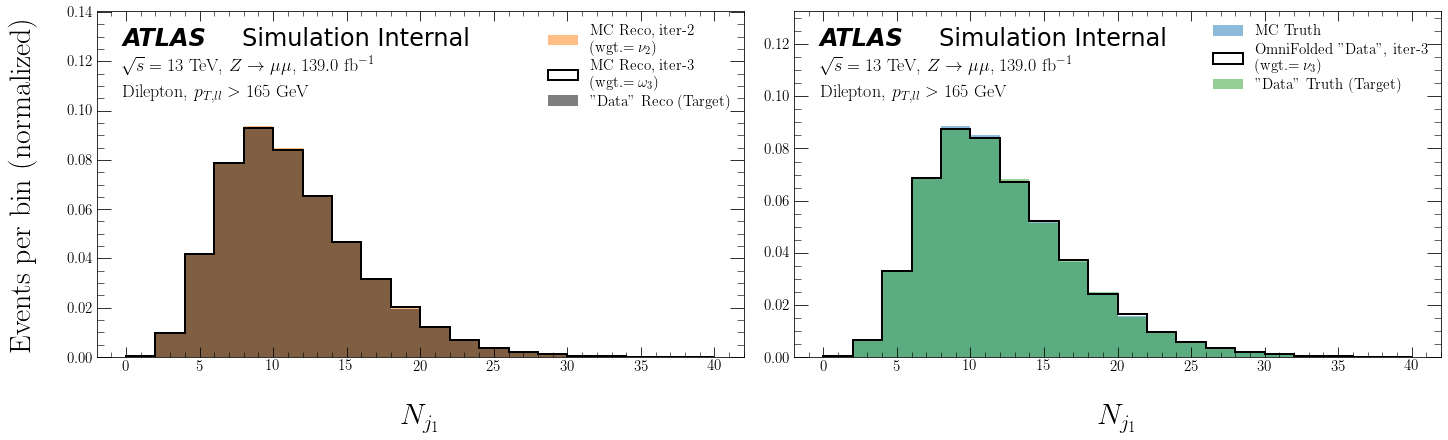

In [41]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_weights_MC=sim_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_weights_MC=data_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             save_label=save_label)

## Unfold $p_{T, j_1}$

In [42]:
K.clear_session()

In [43]:
obs_index = 6  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [44]:
sim_truth, data_truth, sim_reco, data_reco, sim_weights_MC, data_weights_MC = train_test_split(
    Events.events['truth_' + file_label][mypass],
    Events.events[file_label][mypass],
    weights_MC,
    test_size=0.5)

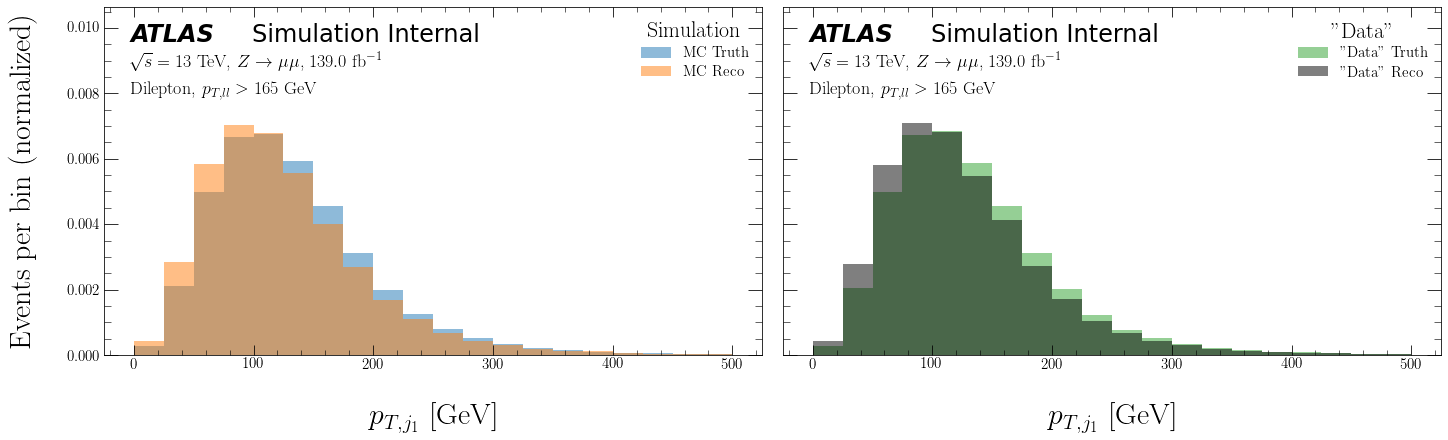

In [45]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_weights_MC=sim_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_weights_MC=data_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [46]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [47]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_weights_MC=sim_weights_MC,
                     data_reco=data_reco_z,
                     data_weights_MC=data_weights_MC)


ITERATION: 1

STEP 1

Epoch 1/200
16/16 [==============================] - 0s 8ms/step - loss: 0.6934 - accuracy: 0.2519 - val_loss: 0.6925 - val_accuracy: 0.2531
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.2522 - val_loss: 0.6925 - val_accuracy: 0.2518
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.2503 - val_loss: 0.6925 - val_accuracy: 0.2510
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.2524 - val_loss: 0.6925 - val_accuracy: 0.2537
Epoch 5/200
16/16 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.2501 - val_loss: 0.6925 - val_accuracy: 0.2518
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.2516 - val_loss: 0.6925 - val_accuracy: 0.2513
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.2501 - val_loss: 0.6925 - val_accurac

Epoch 18/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.2528 - val_loss: 0.6918 - val_accuracy: 0.2510
Epoch 19/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.2500 - val_loss: 0.6918 - val_accuracy: 0.2509
Epoch 00019: early stopping

ITERATION: 3

STEP 1

Epoch 1/200
16/16 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.2505 - val_loss: 0.6913 - val_accuracy: 0.2505
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.2498 - val_loss: 0.6913 - val_accuracy: 0.2501
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.2500 - val_loss: 0.6913 - val_accuracy: 0.2501
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.2503 - val_loss: 0.6913 - val_accuracy: 0.2499
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.2501 - 

#### Results

ITERATION 1:


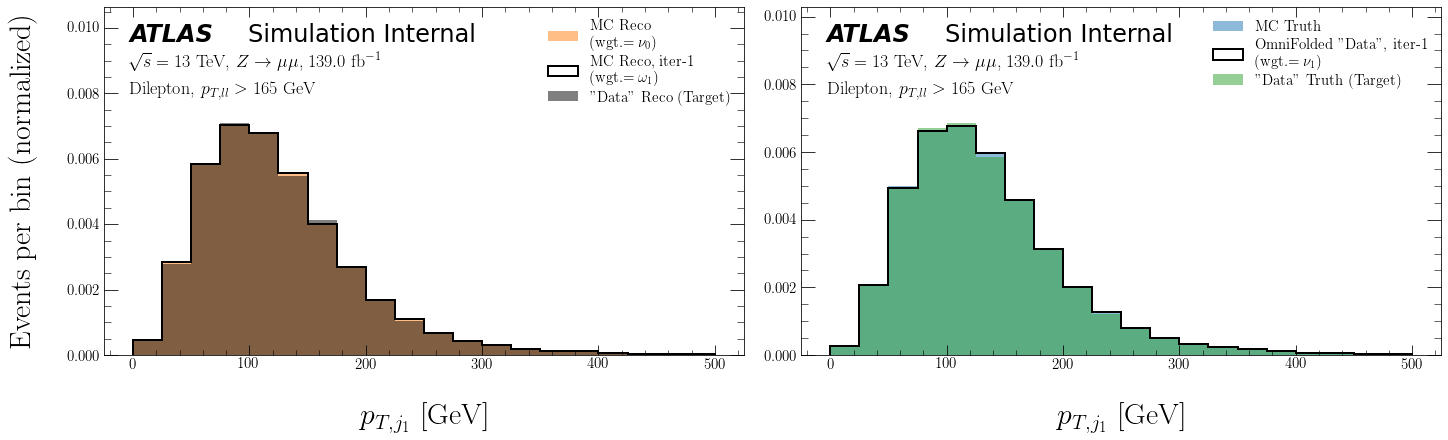

ITERATION 2:


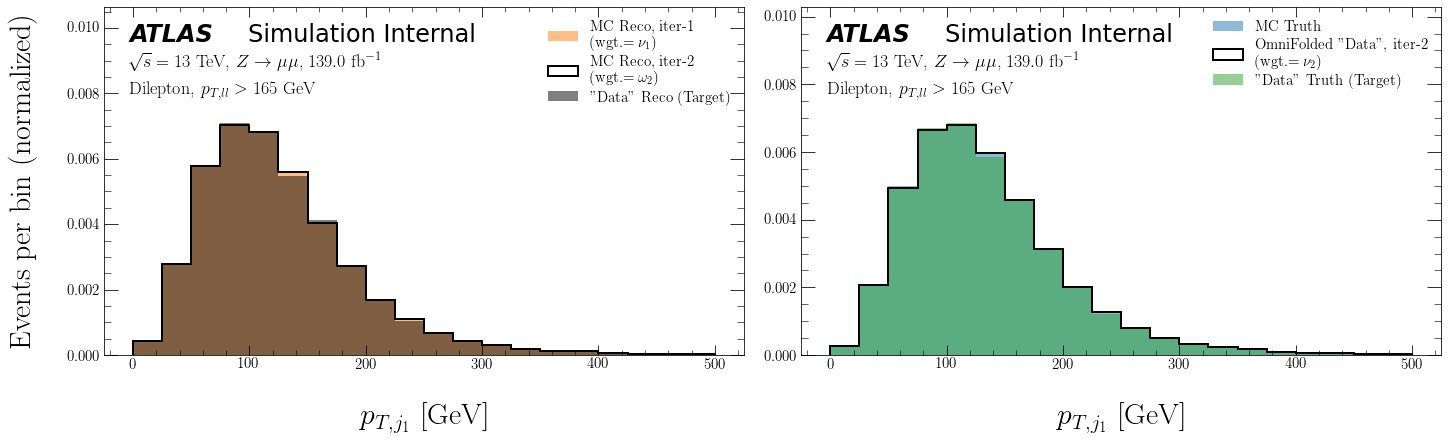

ITERATION 3:


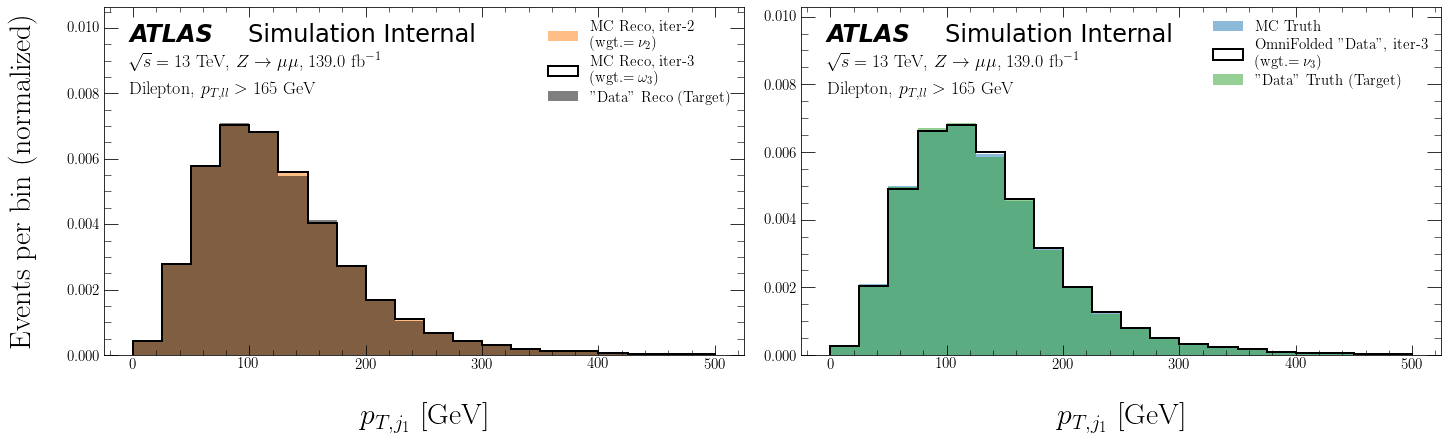

In [48]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_weights_MC=sim_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_weights_MC=data_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             save_label=save_label)

## Unfold $y_{j_1}$

In [49]:
K.clear_session()

In [50]:
obs_index = 10  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [51]:
sim_truth, data_truth, sim_reco, data_reco, sim_weights_MC, data_weights_MC = train_test_split(
    Events.events['truth_' + file_label][mypass],
    Events.events[file_label][mypass],
    weights_MC,
    test_size=0.5)

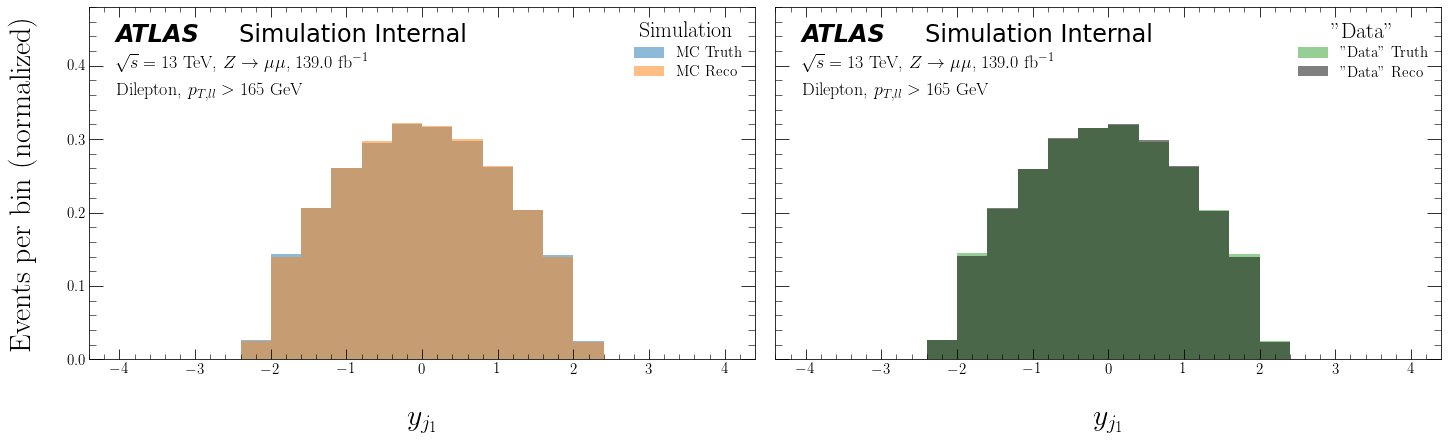

In [52]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_weights_MC=sim_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_weights_MC=data_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [53]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [54]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_weights_MC=sim_weights_MC,
                     data_reco=data_reco_z,
                     data_weights_MC=data_weights_MC)


ITERATION: 1

STEP 1

Epoch 1/200
16/16 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.2509 - val_loss: 0.6940 - val_accuracy: 0.2514
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.2515 - val_loss: 0.6939 - val_accuracy: 0.2511
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.2525 - val_loss: 0.6939 - val_accuracy: 0.2497
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.2515 - val_loss: 0.6939 - val_accuracy: 0.2505
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.2519 - val_loss: 0.6939 - val_accuracy: 0.2508
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.2517 - val_loss: 0.6941 - val_accuracy: 0.2532
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.2520 - val_loss: 0.6939 - val_accurac

Epoch 12/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.2527 - val_loss: 0.6917 - val_accuracy: 0.2500
Epoch 00012: early stopping

ITERATION: 3

STEP 1

Epoch 1/200
16/16 [==============================] - 0s 8ms/step - loss: 0.6944 - accuracy: 0.2510 - val_loss: 0.6937 - val_accuracy: 0.2505
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.2508 - val_loss: 0.6935 - val_accuracy: 0.2526
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.2525 - val_loss: 0.6935 - val_accuracy: 0.2489
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.2525 - val_loss: 0.6935 - val_accuracy: 0.2524
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.2511 - val_loss: 0.6935 - val_accuracy: 0.2531
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.2512 - v

#### Results

ITERATION 1:


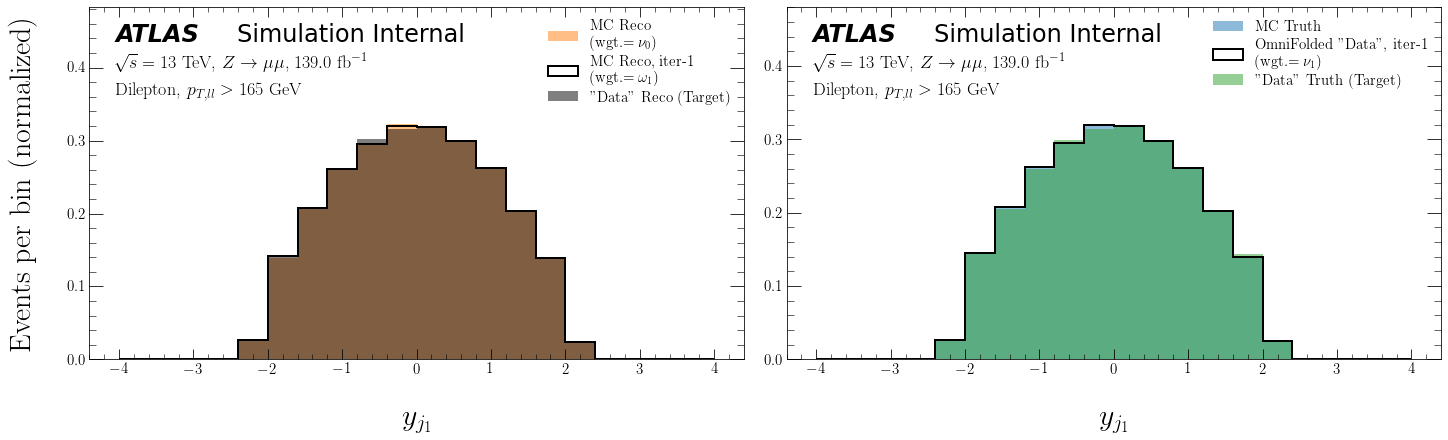

ITERATION 2:


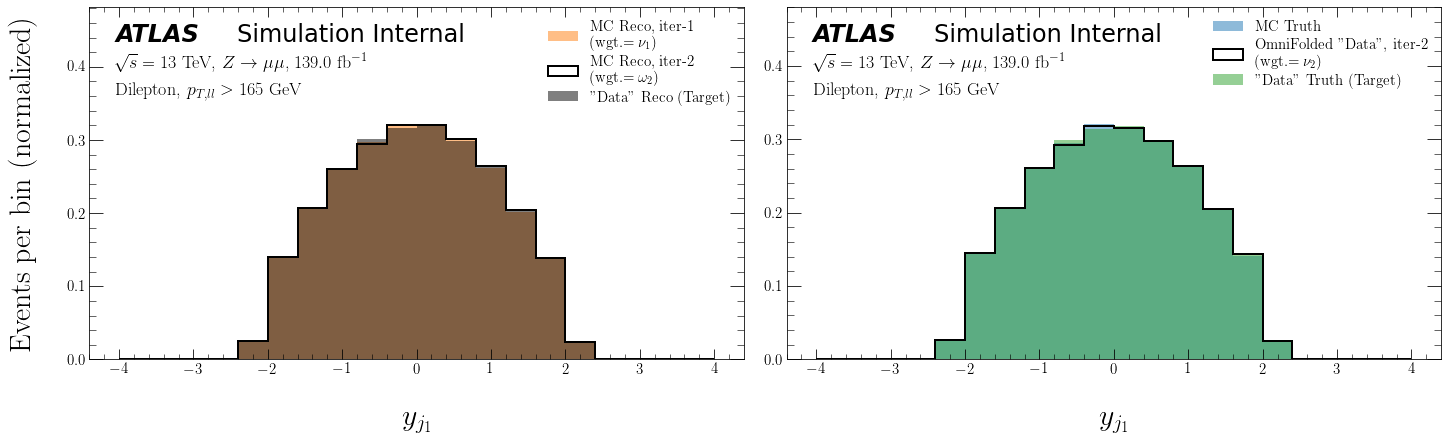

ITERATION 3:


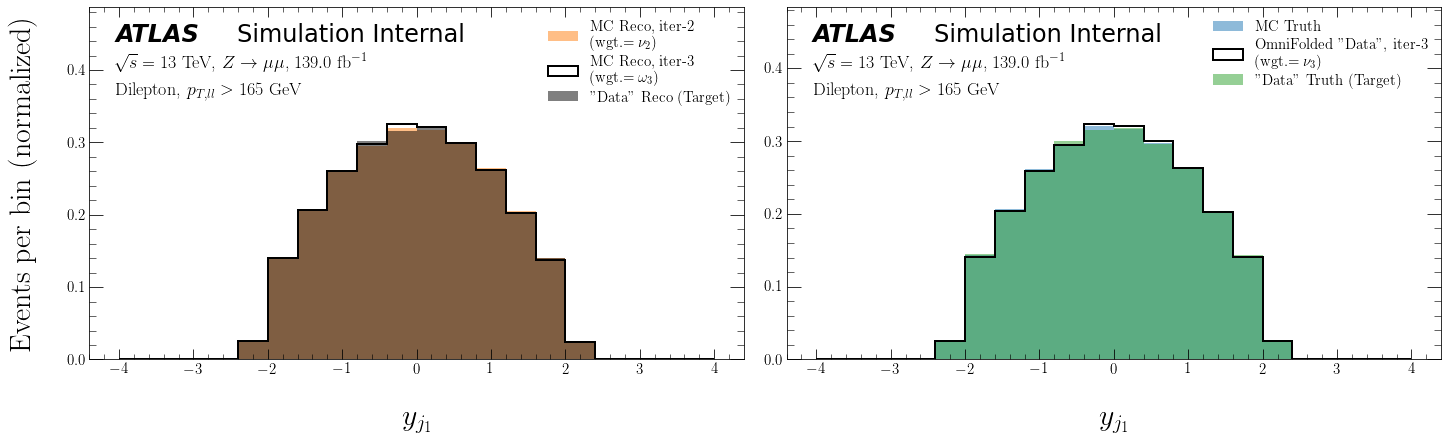

In [55]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_weights_MC=sim_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_weights_MC=data_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             save_label=save_label)

## Unfold $\tau _{j_1}$

In [56]:
K.clear_session()

In [57]:
obs_index = 4  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [58]:
sim_truth, data_truth, sim_reco, data_reco, sim_weights_MC, data_weights_MC = train_test_split(
    Events.events['truth_' + file_label][mypass],
    Events.events[file_label][mypass],
    weights_MC,
    test_size=0.5)

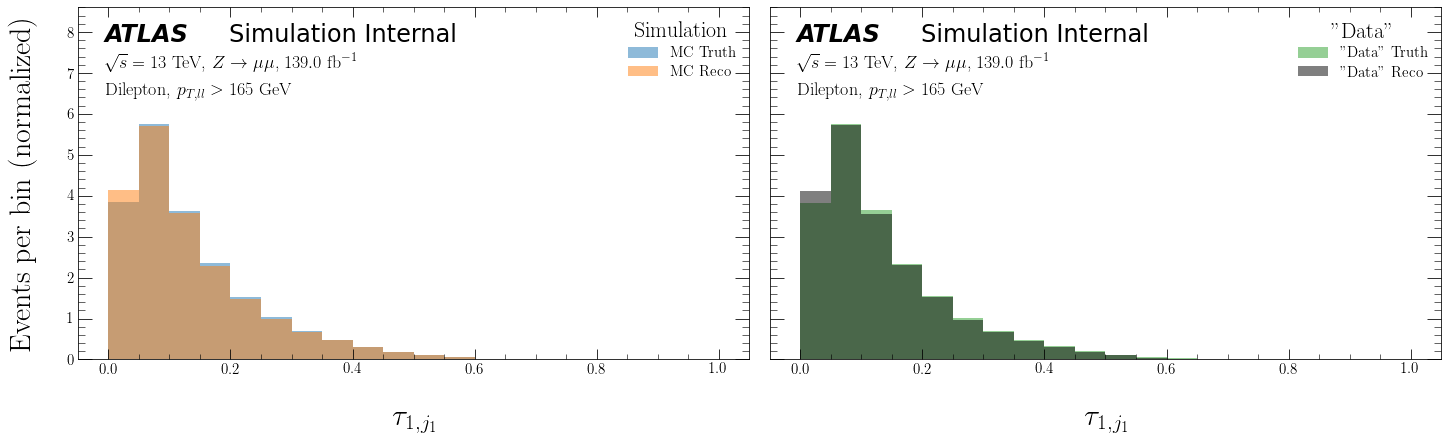

In [59]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_weights_MC=sim_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_weights_MC=data_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [60]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [61]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_weights_MC=sim_weights_MC,
                     data_reco=data_reco_z,
                     data_weights_MC=data_weights_MC)


ITERATION: 1

STEP 1

Epoch 1/200
16/16 [==============================] - 0s 8ms/step - loss: 0.6939 - accuracy: 0.2511 - val_loss: 0.6930 - val_accuracy: 0.2541
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.2517 - val_loss: 0.6931 - val_accuracy: 0.2511
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.2520 - val_loss: 0.6931 - val_accuracy: 0.2511
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.2519 - val_loss: 0.6931 - val_accuracy: 0.2493
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.2510 - val_loss: 0.6931 - val_accuracy: 0.2503
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.2505 - val_loss: 0.6931 - val_accuracy: 0.2526
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.2512 - val_loss: 0.6931 - val_accurac

Epoch 19/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2522 - val_loss: 0.6926 - val_accuracy: 0.2508
Epoch 20/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.2527 - val_loss: 0.6926 - val_accuracy: 0.2508
Epoch 21/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.2532 - val_loss: 0.6926 - val_accuracy: 0.2504
Epoch 22/200
16/16 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.2504 - val_loss: 0.6926 - val_accuracy: 0.2508
Epoch 23/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2523 - val_loss: 0.6926 - val_accuracy: 0.2504
Epoch 24/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2520 - val_loss: 0.6926 - val_accuracy: 0.2510
Epoch 25/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.2525 - val_loss: 0.6926 - val_accuracy: 0.2506
Epoch 

#### Results

ITERATION 1:


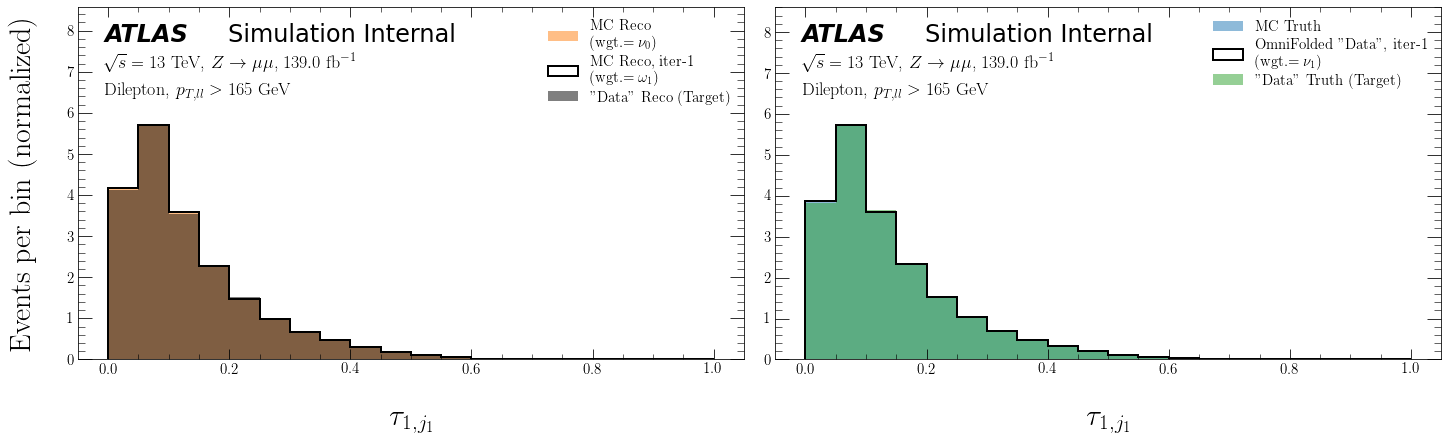

ITERATION 2:


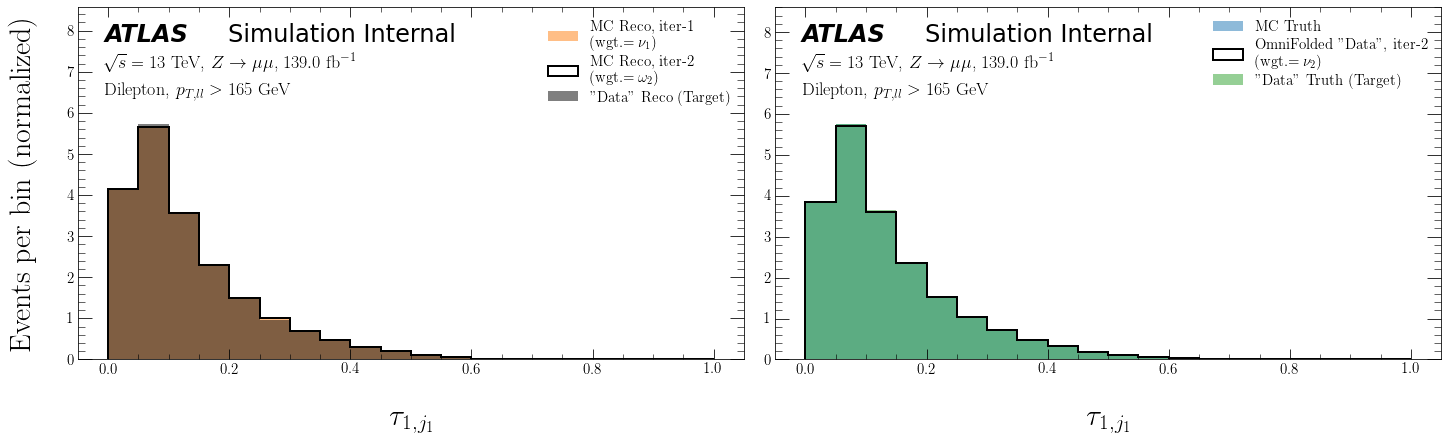

ITERATION 3:


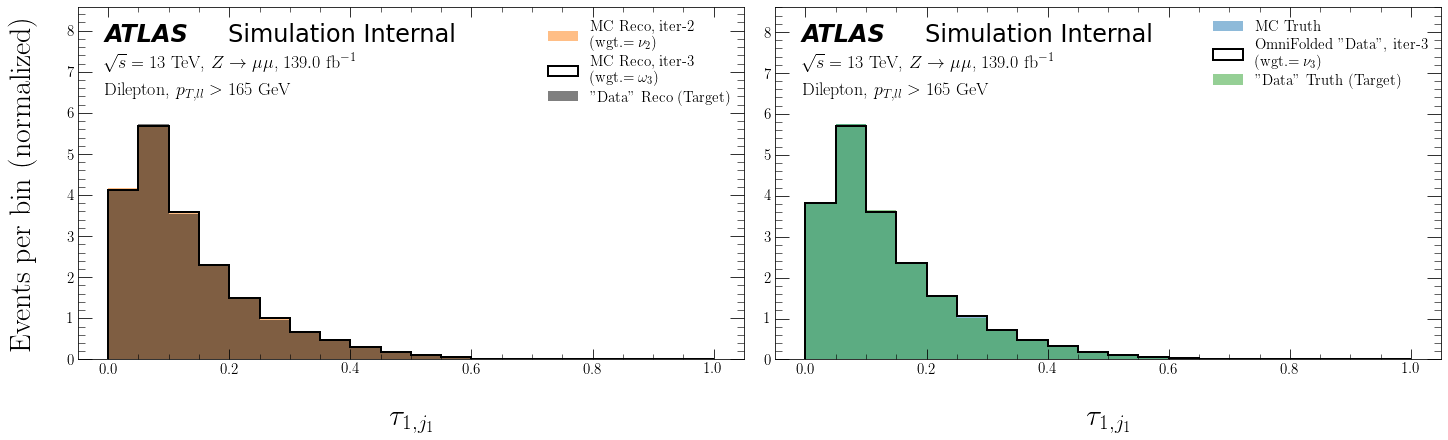

In [62]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_weights_MC=sim_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_weights_MC=data_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             save_label=save_label)

# MultiFold

To show unfolding of multiple observables simultaneously ("MultiFold"), we will unfold the following observables together: the leading jet mass $m_{j_1}$, the leading jet number of constituents (tracks) $N_{j_1}$, the leading jet transverse momentum $p_{T,j_1}$, the leading jet rapidity $y_{j_1}$, the leading jet $n$-subjettiness ($\tau_{1, j_1}$, $\tau_{2, j_1}$, $\tau_{3, j_1}$), the subleading jet mass $m_{j_2}$, the subleading jet number of constituents (tracks) $N_{j_2}$, the subleading jet transverse momentum $p_{T,j_2}$, the subleading jet rapidity $y_{j_2}$, the subleading jet $n$-subjettiness ($\tau_{1, j_2}$, $\tau_{2, j_2}$, $\tau_{3, j_2}$), the dilepton transverse momentum $p_{T,ll}$, and the dilepton rapidity $y_{ll}$ for a total of **16 observables**.

In [63]:
K.clear_session()

## Setup datasets

In [64]:
sim, data = train_test_split(np.arange(np.sum(mypass)), test_size=0.5)

In [65]:
sim_truth = [None] * len(obs)
sim_reco = [None] * len(obs)
data_truth = [None] * len(obs)
data_reco = [None] * len(obs)

In [66]:
for i in range(len(obs)):
    file_label = obs[i]['file_label']

    sim_truth[i] = Events.events['truth_' + file_label][mypass][sim]
    sim_reco[i] = Events.events[file_label][mypass][sim]
    data_truth[i] = Events.events['truth_' + file_label][mypass][data]
    data_reco[i] = Events.events[file_label][mypass][data]

sim_weights_MC = weights_MC[sim]
data_weights_MC = weights_MC[data]

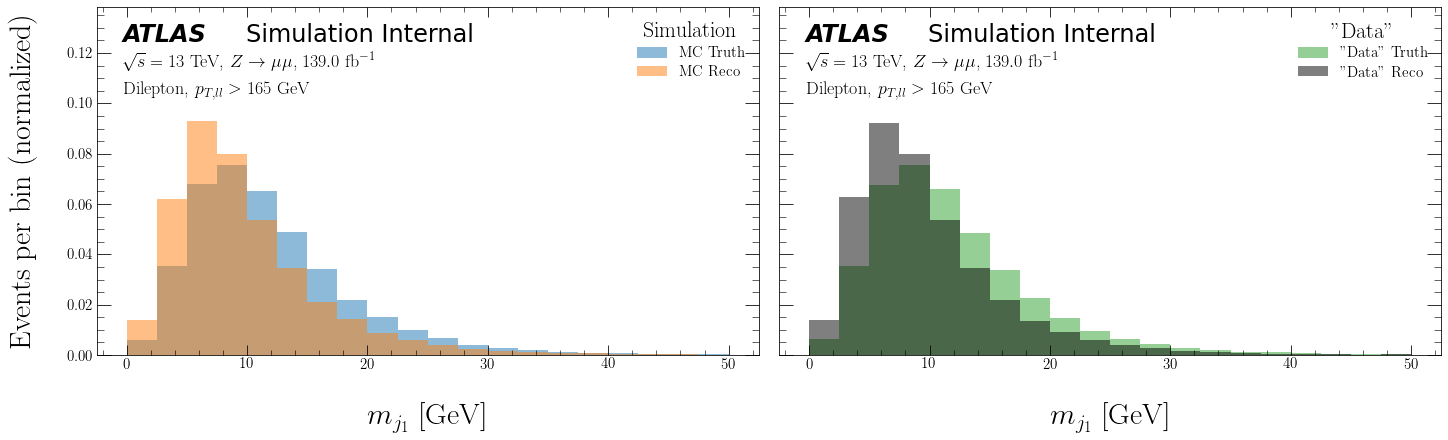

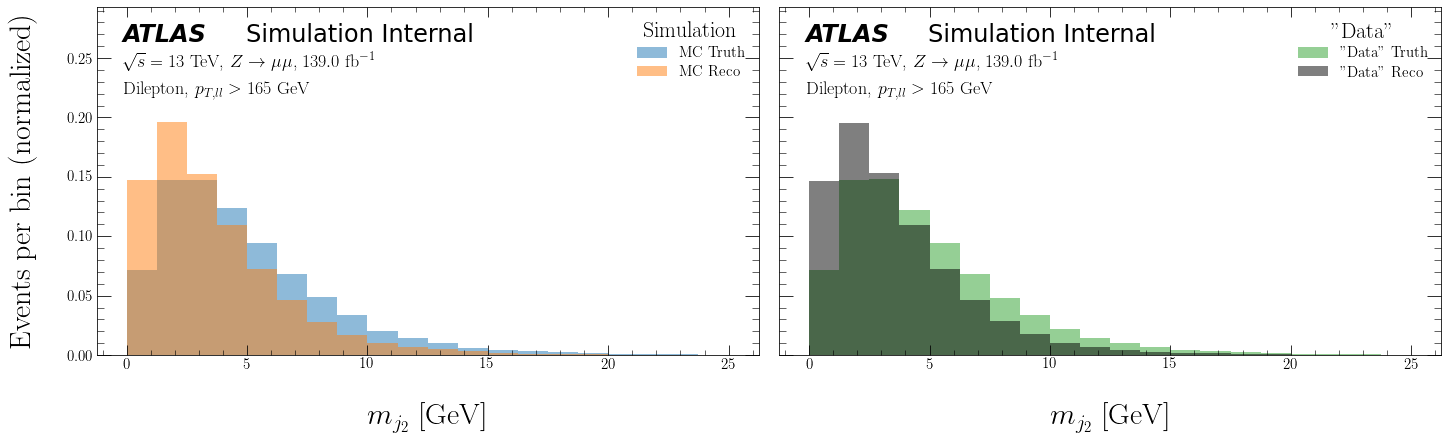

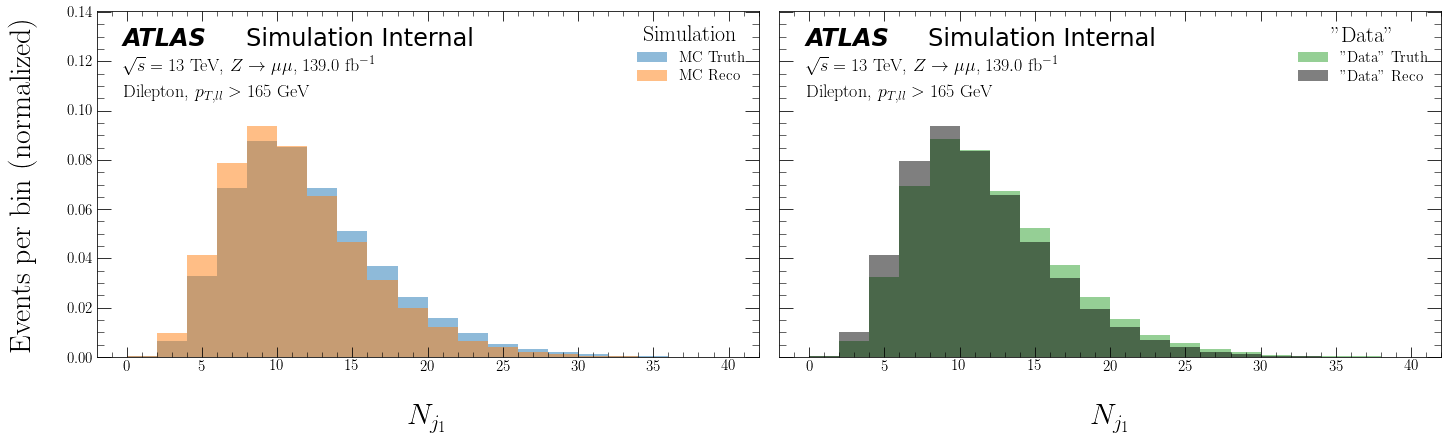

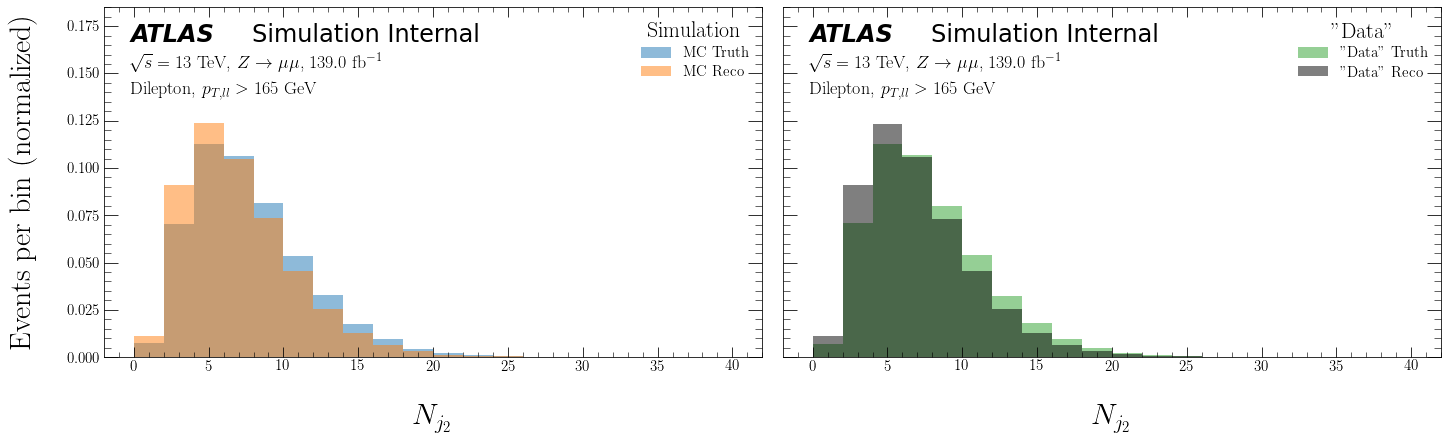

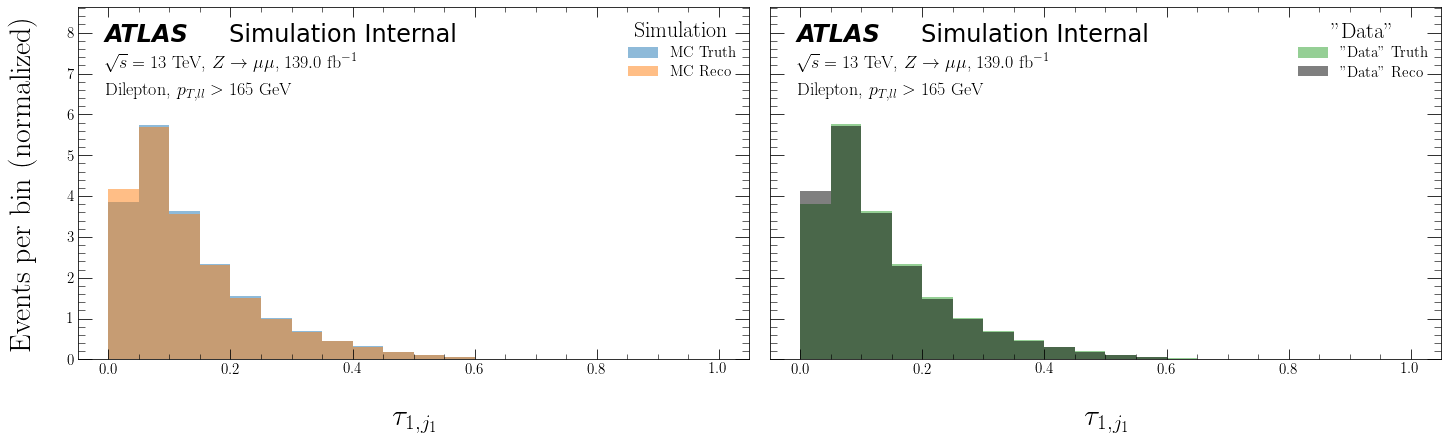

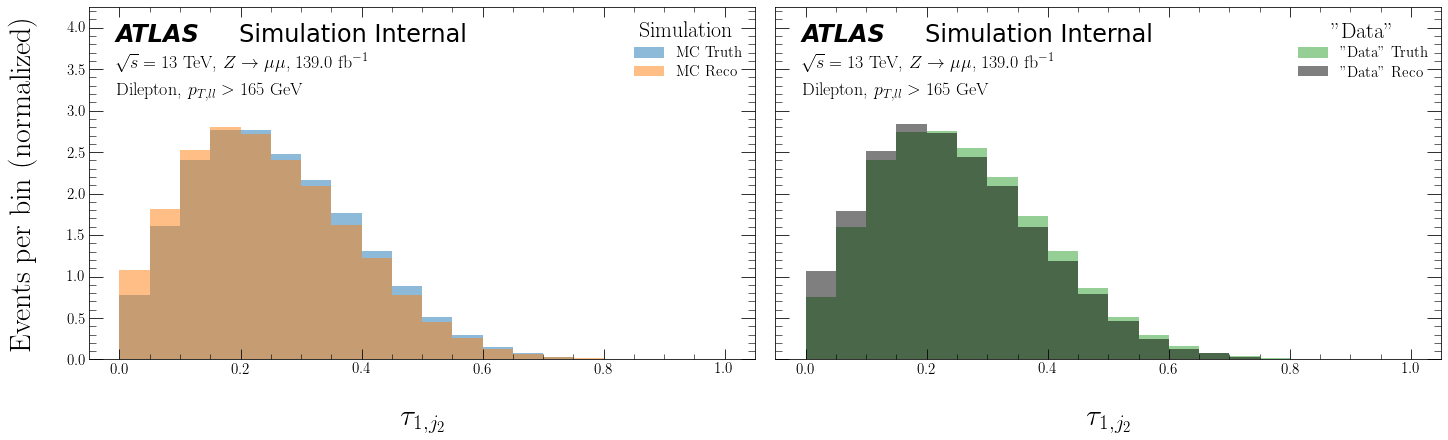

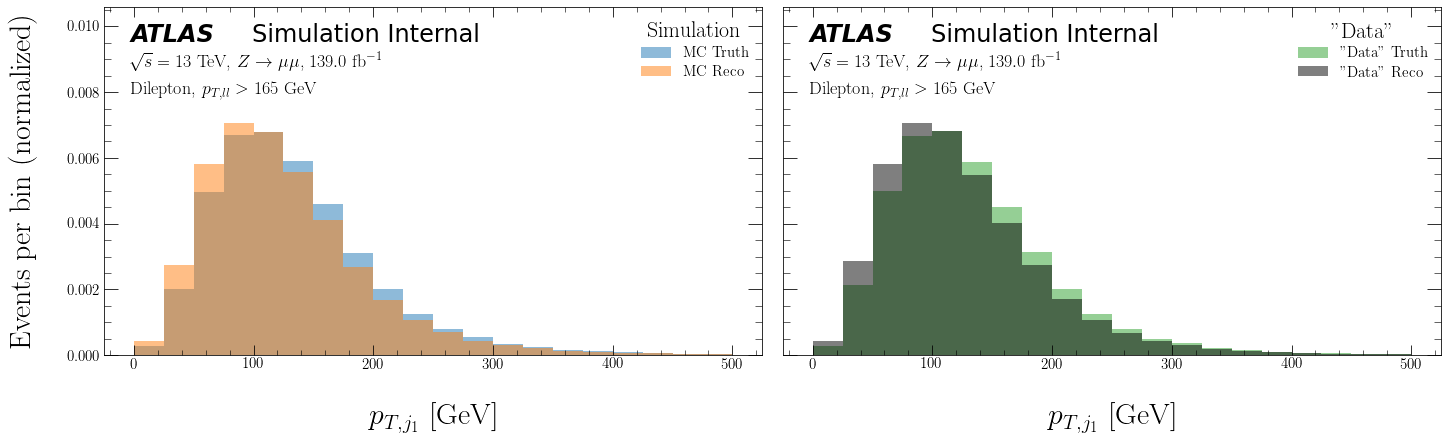

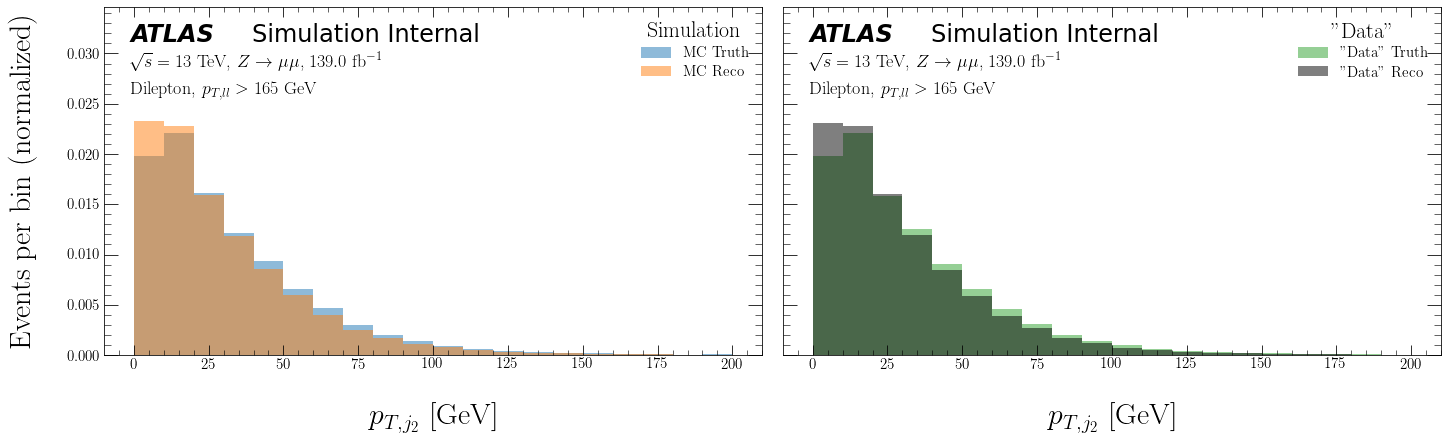

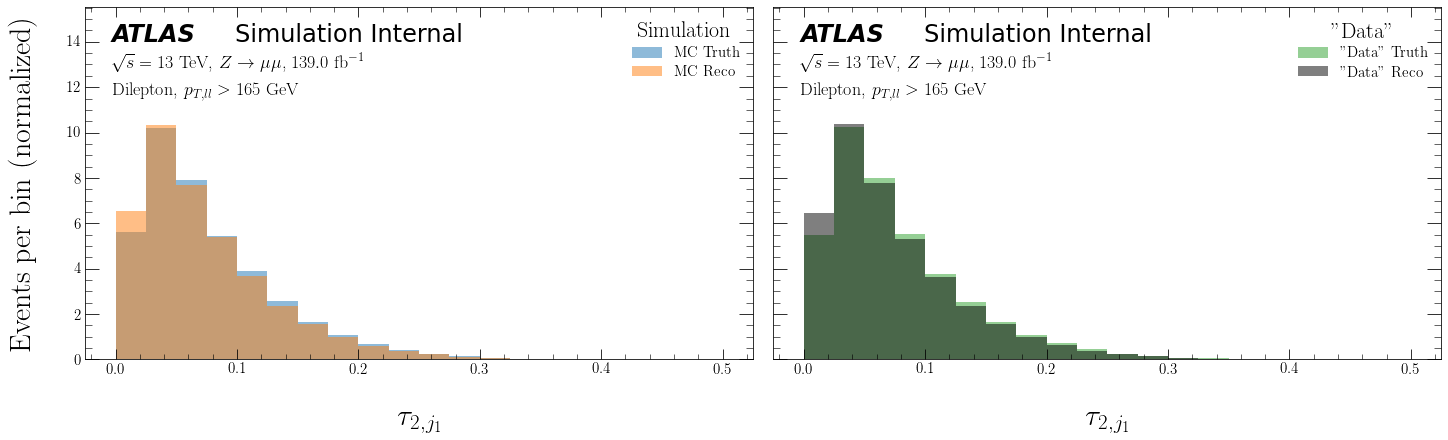

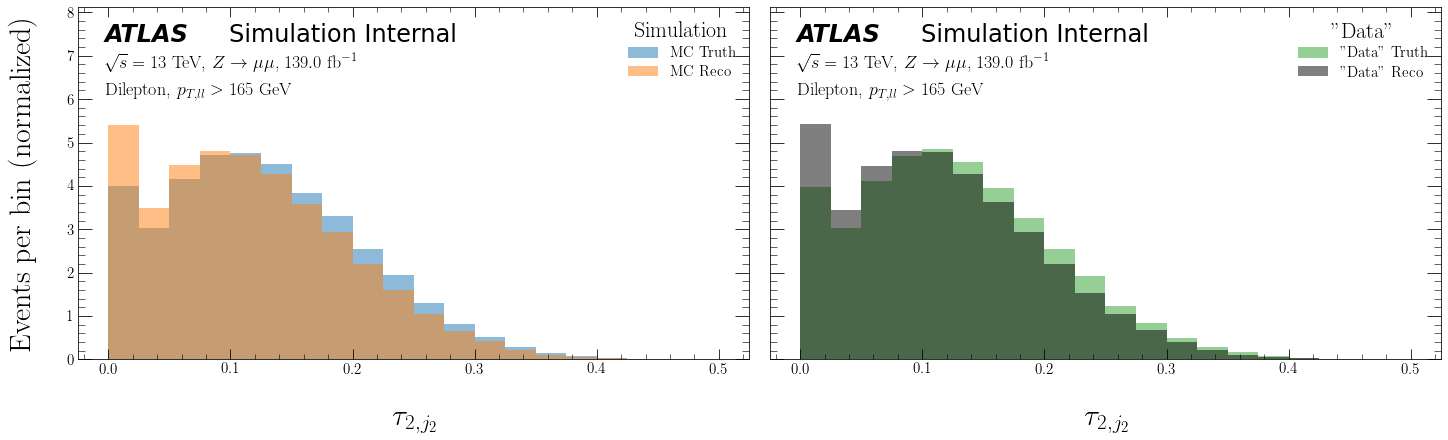

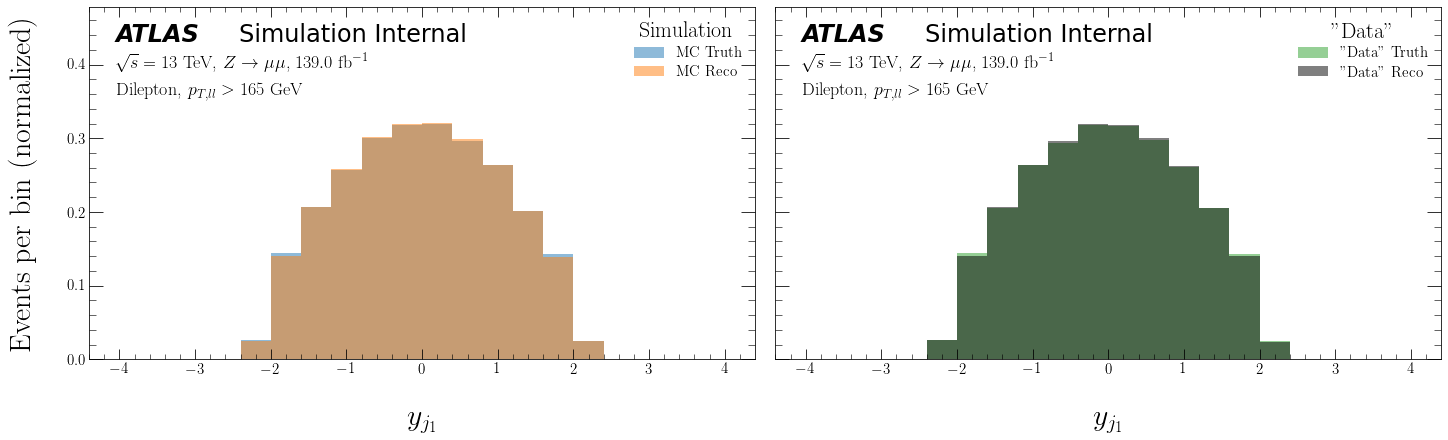

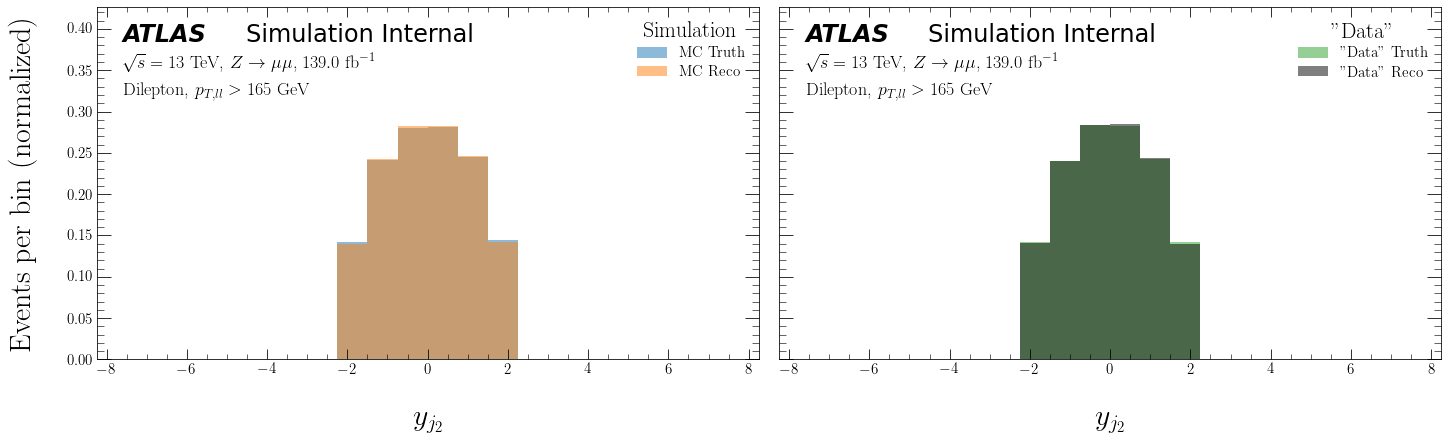

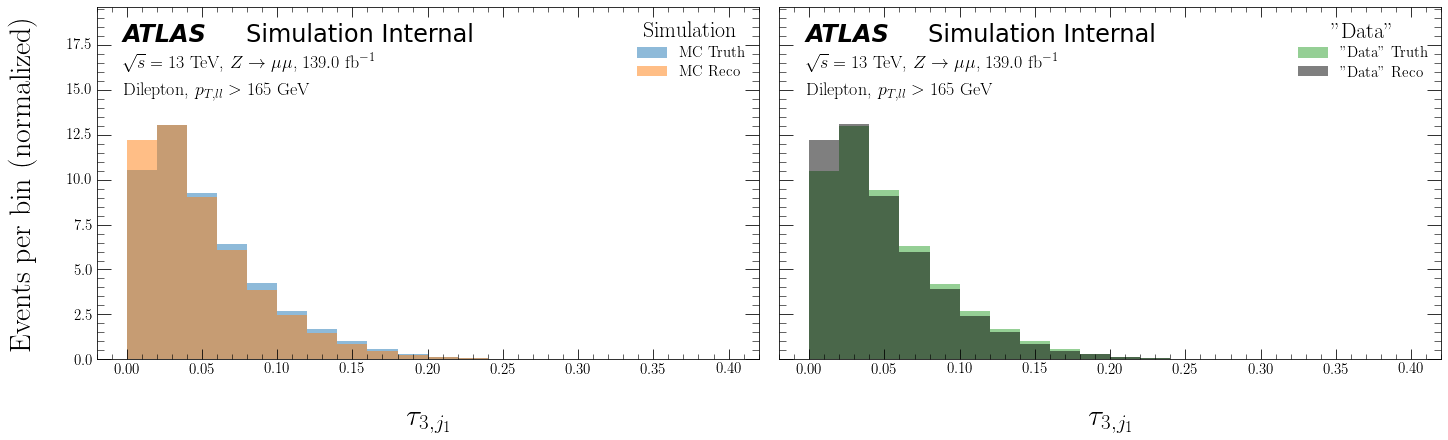

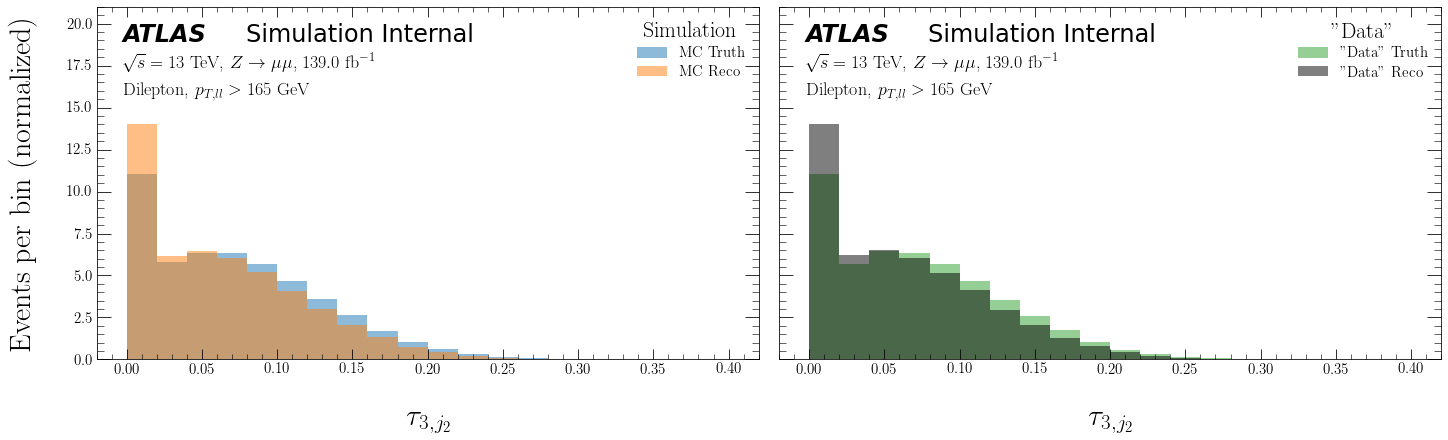

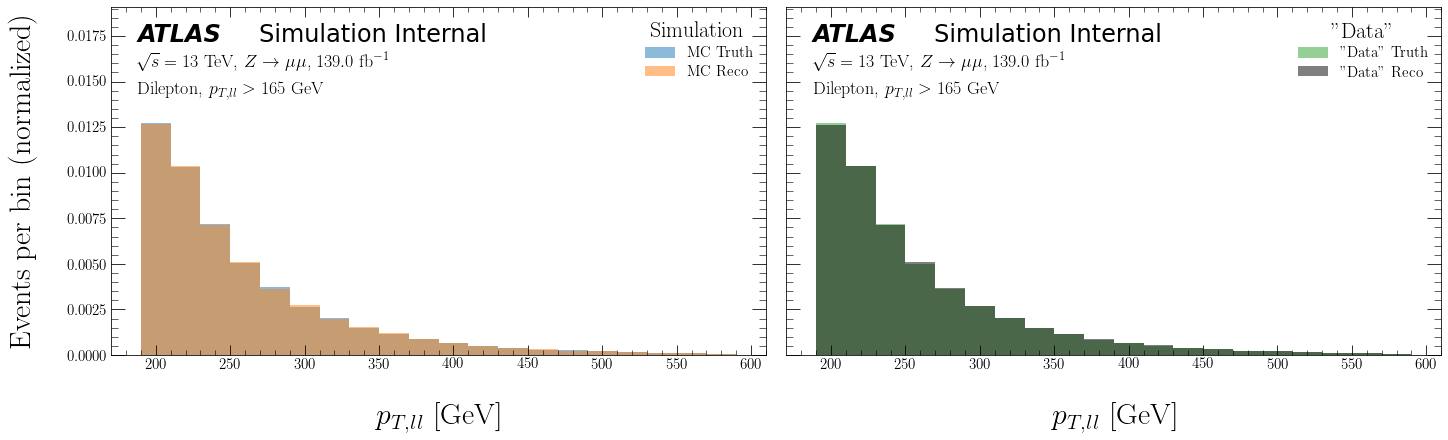

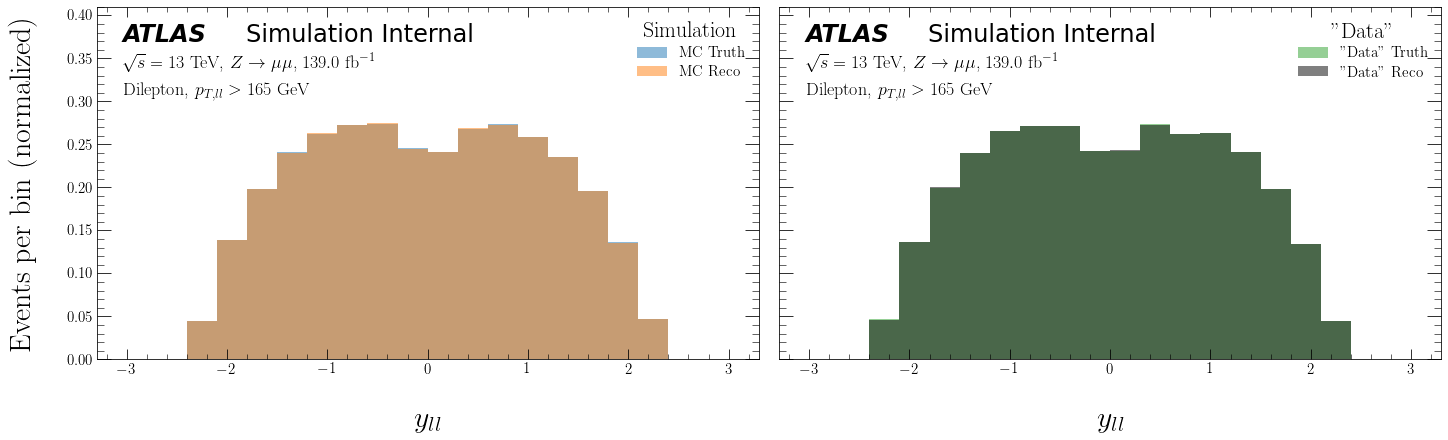

In [67]:
for i in range(len(obs)):
    bins = obs[i]['bins']
    x_label = obs[i]['plot_label']
    file_label = obs[i]['file_label']
    save_label = plot_dir + 'MultiFold/' + file_label + '/' + save_label0 + '-MultiFold-' + file_label
    plot_distributions(sim_truth=sim_truth[i],
                       sim_reco=sim_reco[i],
                       sim_weights_MC=sim_weights_MC,
                       data_truth=data_truth[i],
                       data_reco=data_reco[i],
                       data_weights_MC=data_weights_MC,
                       bins=bins,
                       x_label=x_label,
                       save_label=save_label)

## Unfold 

In [68]:
# z-score standardization of data
sim_truth_z = [None] * len(obs)
sim_reco_z = [None] * len(obs)
data_reco_z = [None] * len(obs)

for i in range(len(obs)):
    sim_truth_z[i], sim_reco_z[i], data_reco_z[i] = standardize(
        sim_truth[i], sim_reco[i], data_reco[i])

In [69]:
weights, _ = multifold(iterations=3,
                       sim_truth=sim_truth_z,
                       sim_reco=sim_reco_z,
                       sim_weights_MC=sim_weights_MC,
                       data_reco=data_reco_z,
                       data_weights_MC=data_weights_MC)


ITERATION: 1

STEP 1

Epoch 1/200
16/16 [==============================] - 0s 8ms/step - loss: 0.6961 - accuracy: 0.2516 - val_loss: 0.6936 - val_accuracy: 0.2516
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.2527 - val_loss: 0.6933 - val_accuracy: 0.2523
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.2550 - val_loss: 0.6933 - val_accuracy: 0.2528
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.2554 - val_loss: 0.6932 - val_accuracy: 0.2514
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.2571 - val_loss: 0.6933 - val_accuracy: 0.2503
Epoch 6/200
16/16 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.2575 - val_loss: 0.6932 - val_accuracy: 0.2506
Epoch 7/200
16/16 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.2573 - val_loss: 0.6933 - val_accurac

Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.2586 - val_loss: 0.6881 - val_accuracy: 0.2519
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.2586 - val_loss: 0.6881 - val_accuracy: 0.2525
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.2593 - val_loss: 0.6882 - val_accuracy: 0.2519
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.2597 - val_loss: 0.6882 - val_accuracy: 0.2533
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.2607 - val_loss: 0.6883 - val_accuracy: 0.2520
Epoch 8/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.2603 - val_loss: 0.6884 - val_accuracy: 0.2521
Epoch 9/200
16/16 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.2615 - val_loss: 0.6883 - val_accuracy: 0.2515
Epoch 10/200


#### Results

m_trackj1 Results

ITERATION 1:


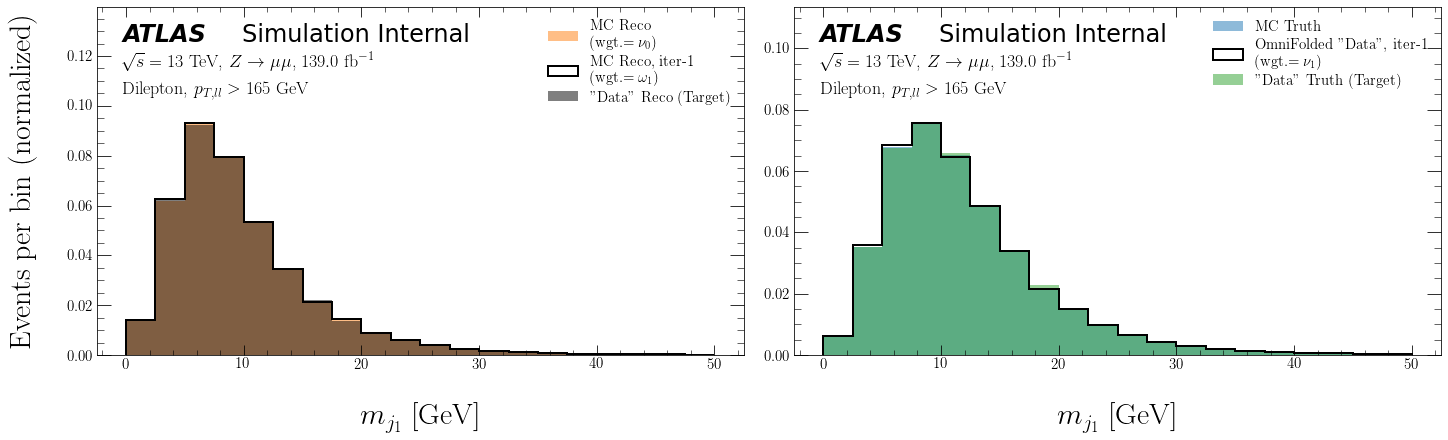

ITERATION 2:


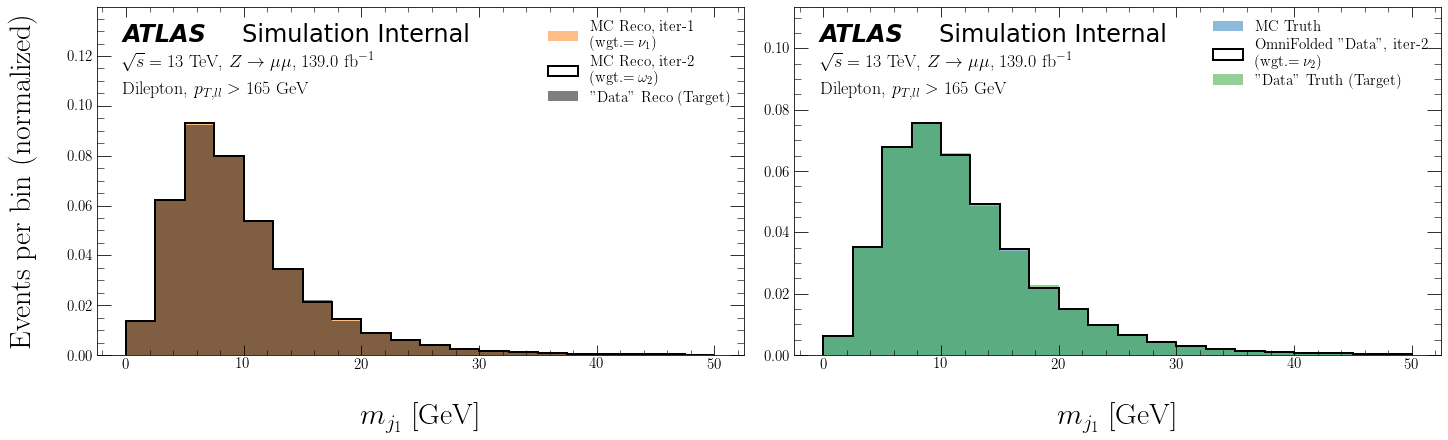

ITERATION 3:


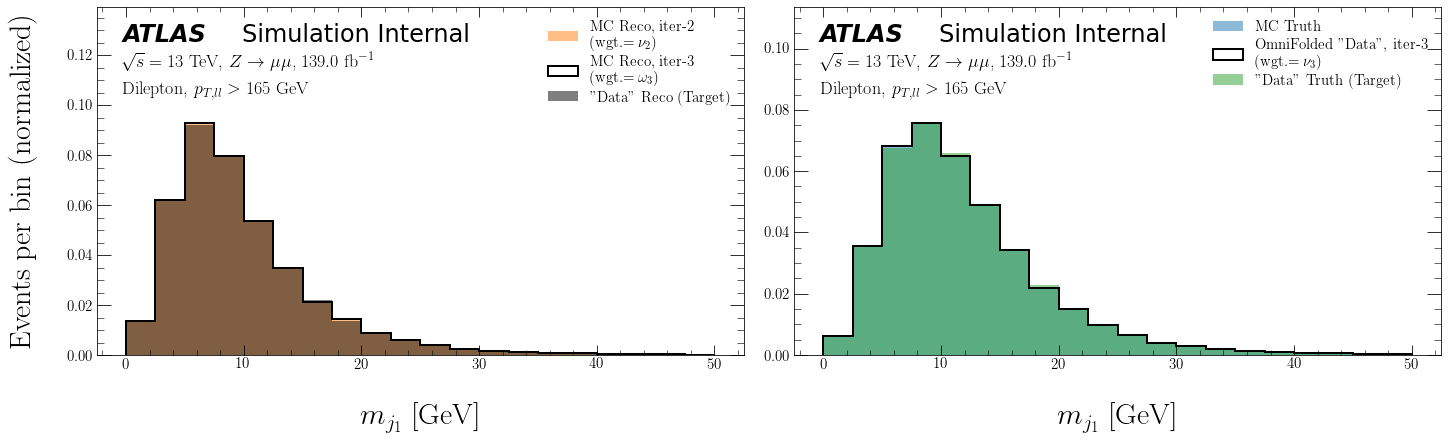

m_trackj2 Results

ITERATION 1:


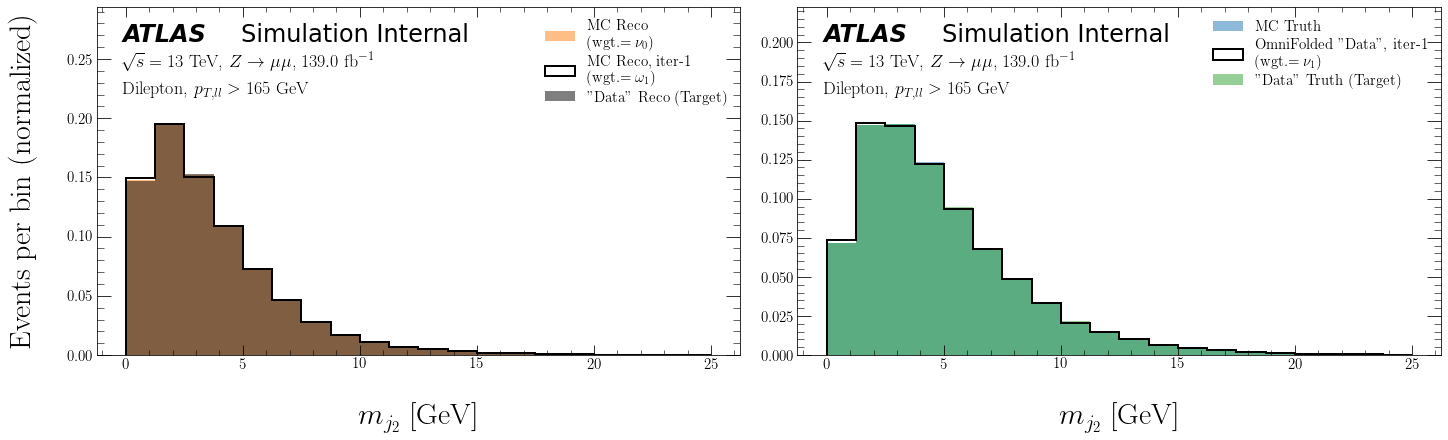

ITERATION 2:


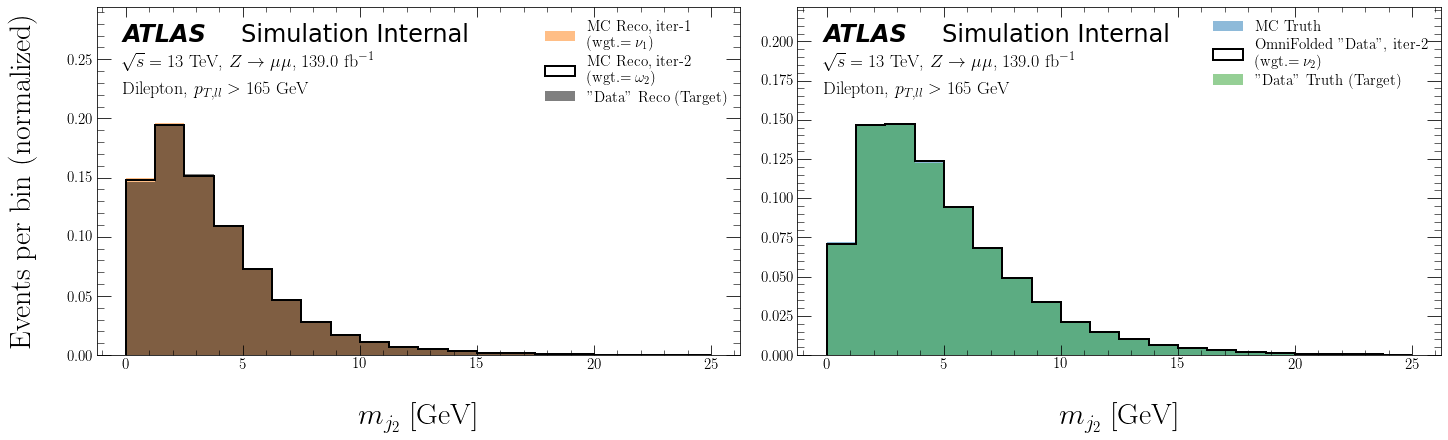

ITERATION 3:


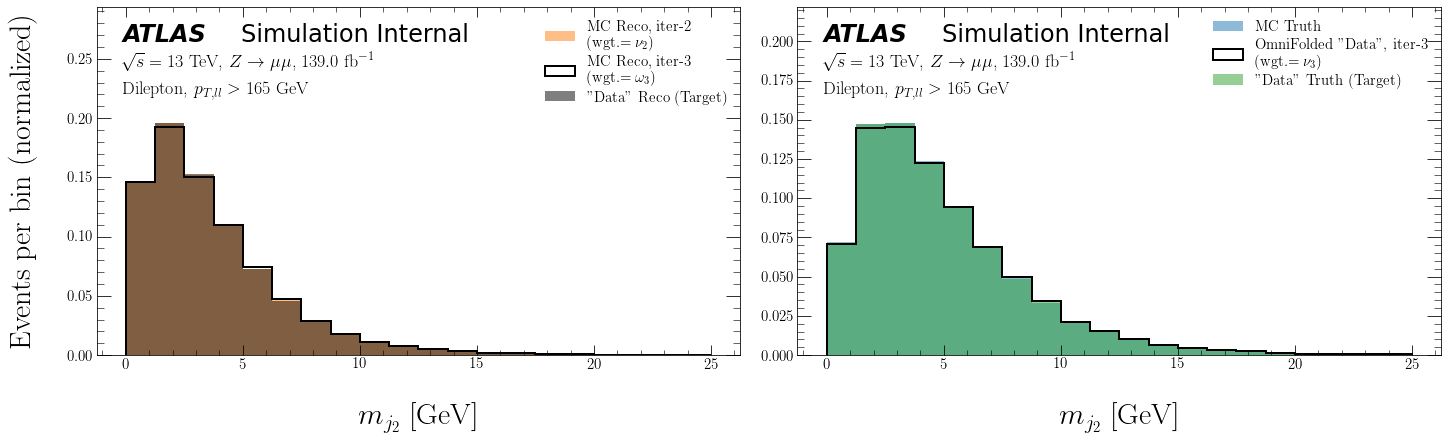

Ntracks_trackj1 Results

ITERATION 1:


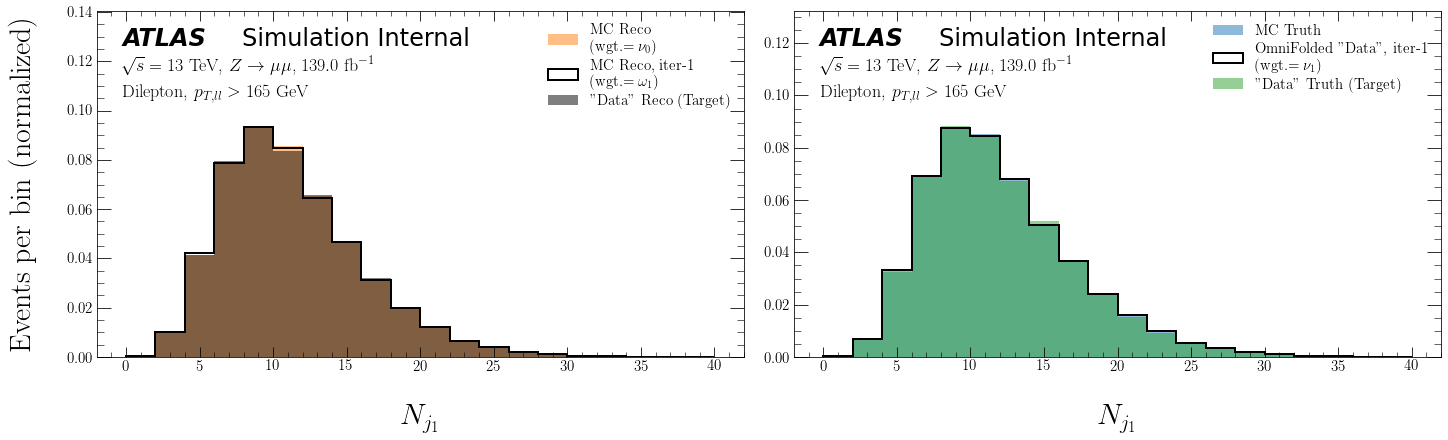

ITERATION 2:


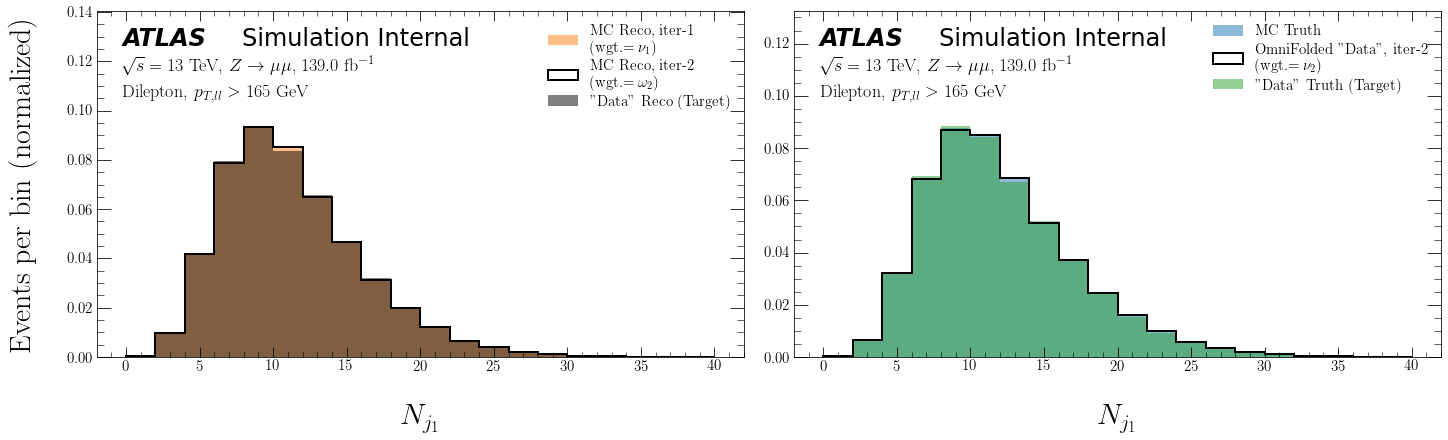

ITERATION 3:


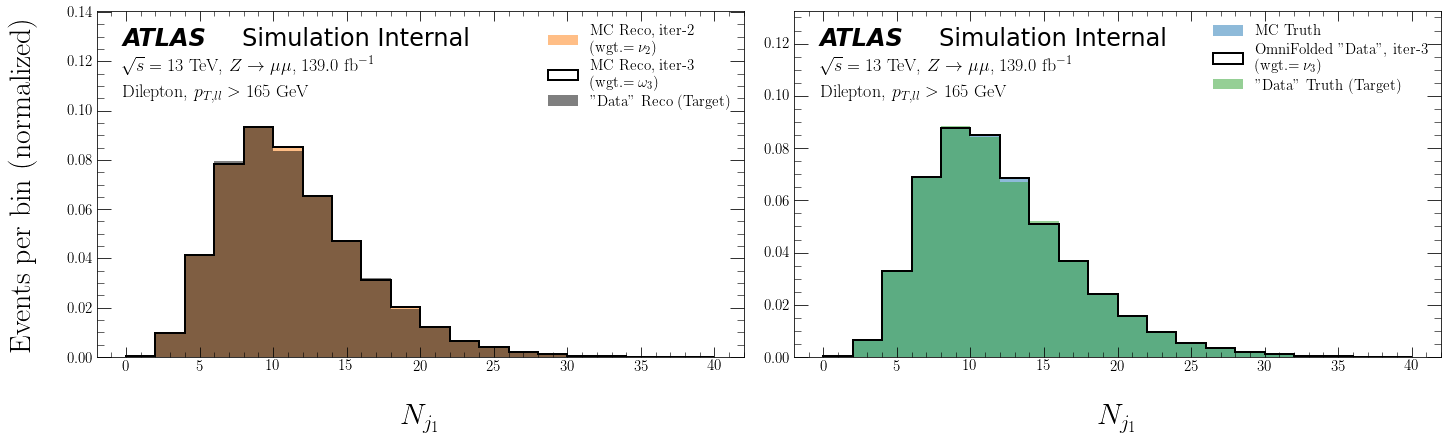

Ntracks_trackj2 Results

ITERATION 1:


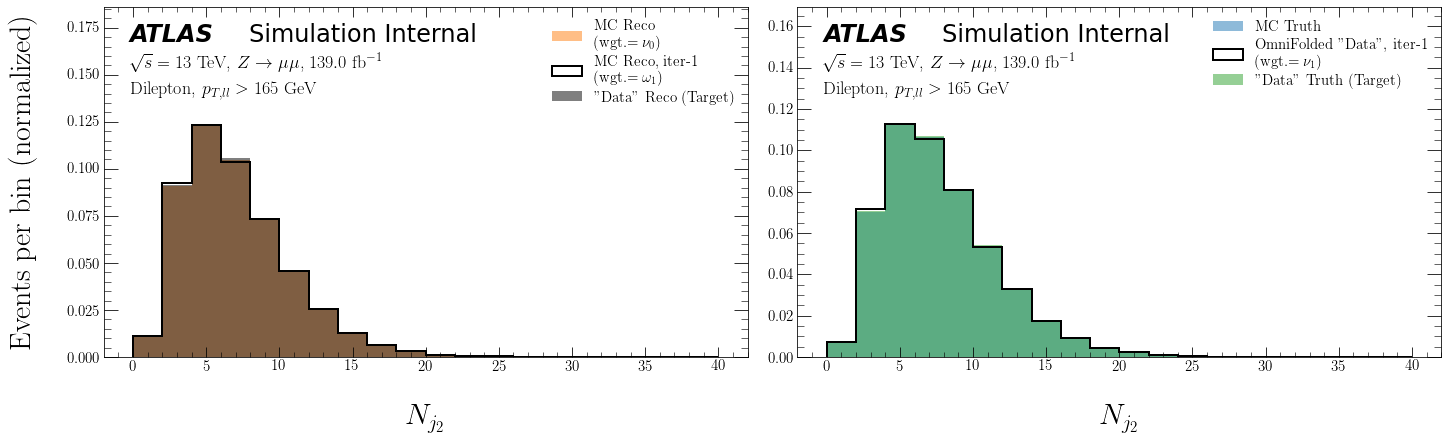

ITERATION 2:


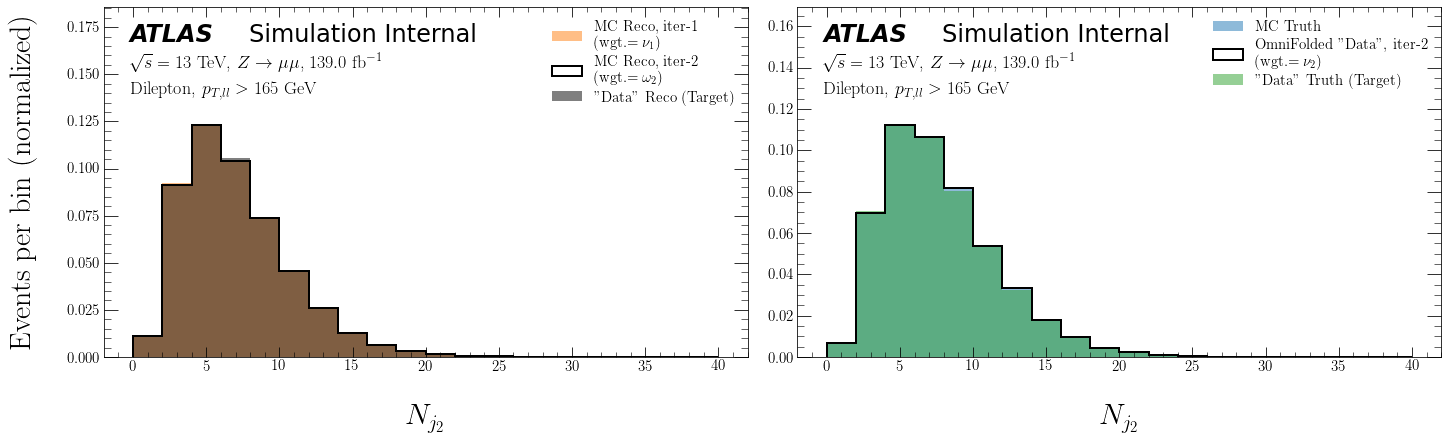

ITERATION 3:


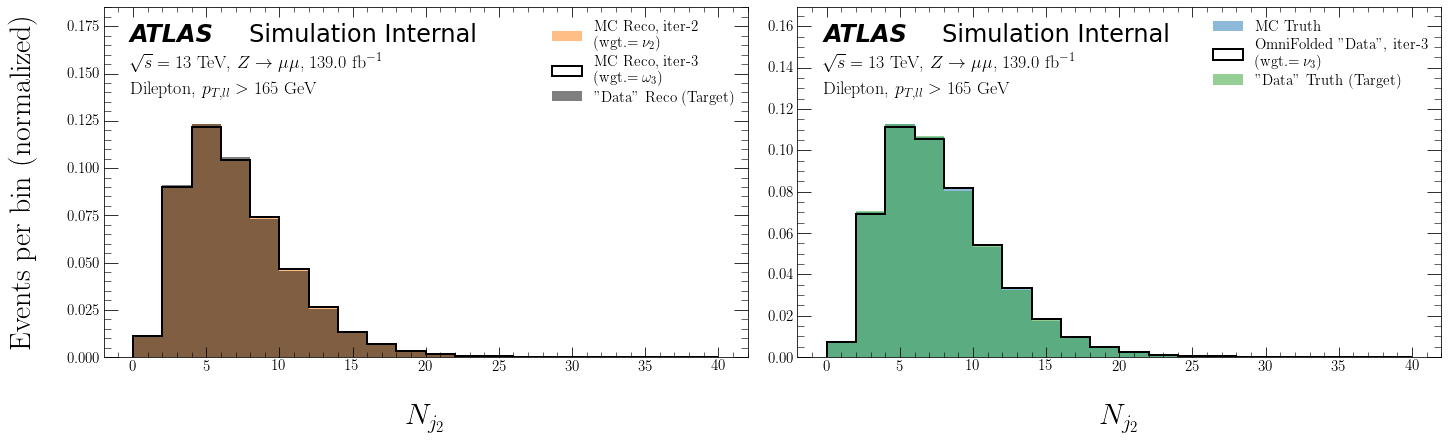

tau1_trackj1 Results

ITERATION 1:


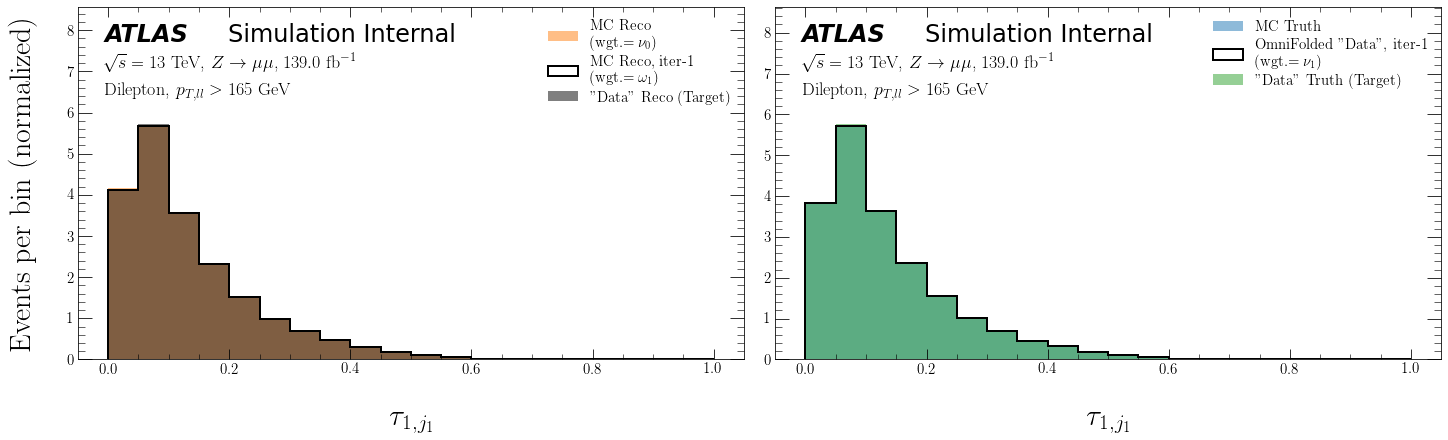

ITERATION 2:


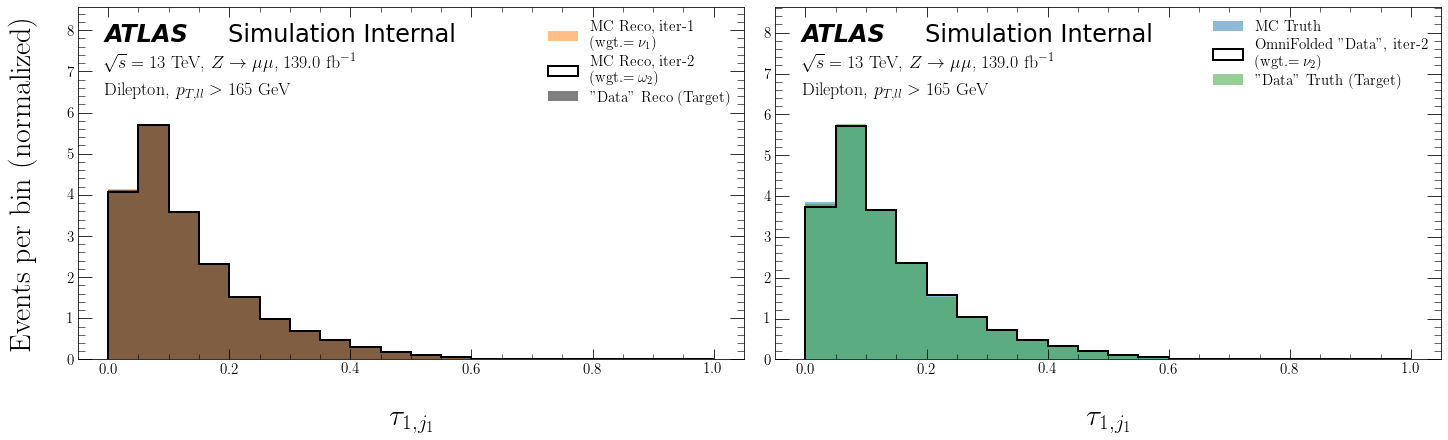

ITERATION 3:


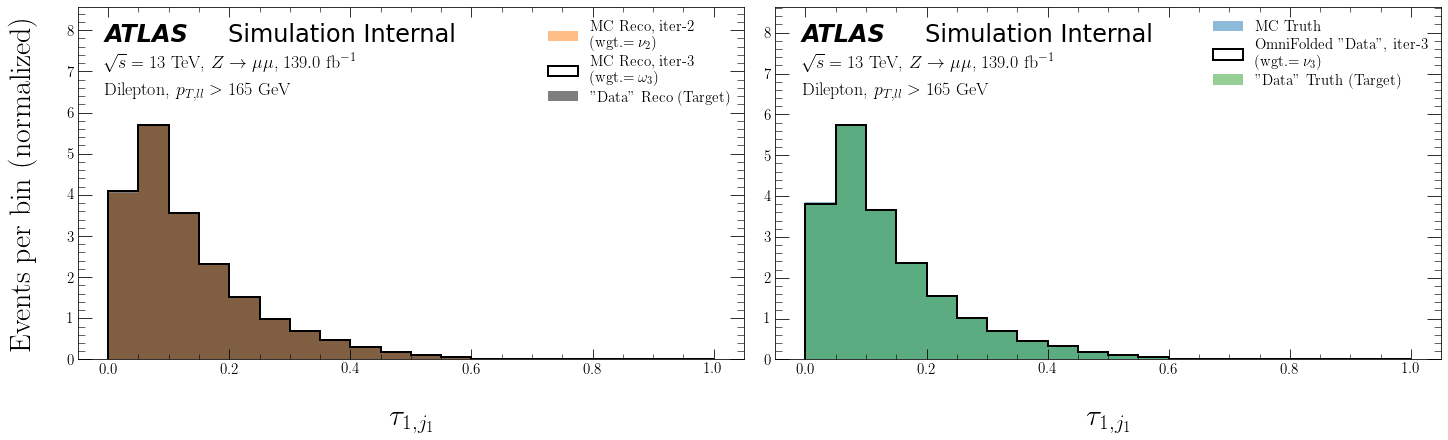

tau1_trackj2 Results

ITERATION 1:


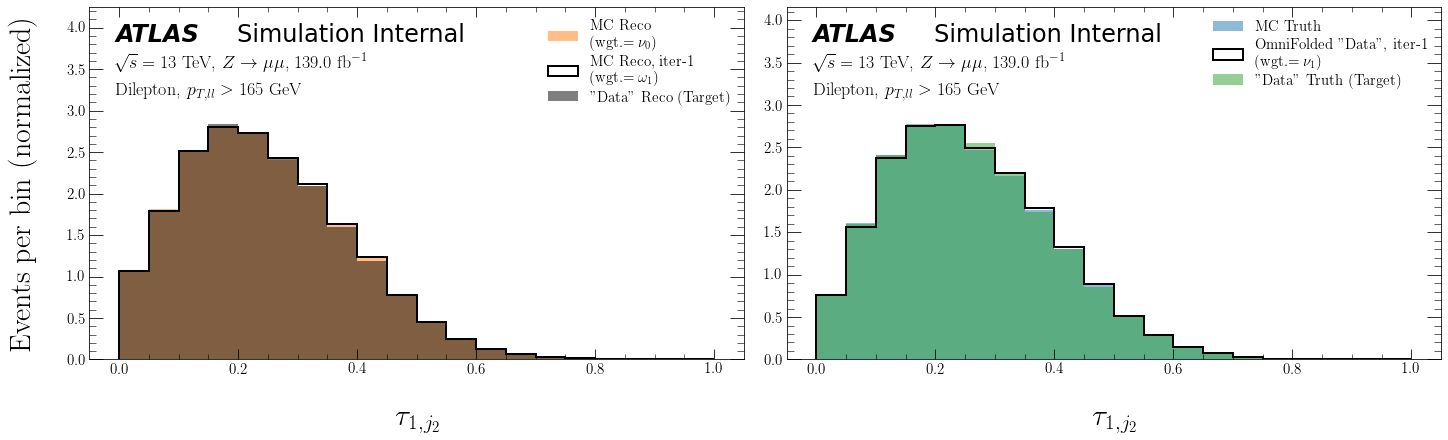

ITERATION 2:


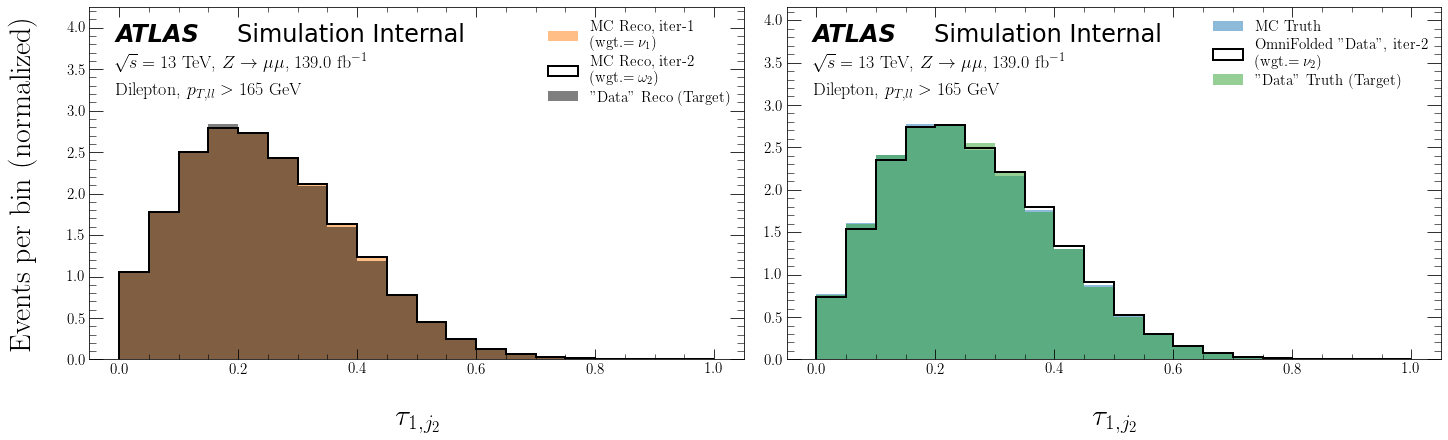

ITERATION 3:


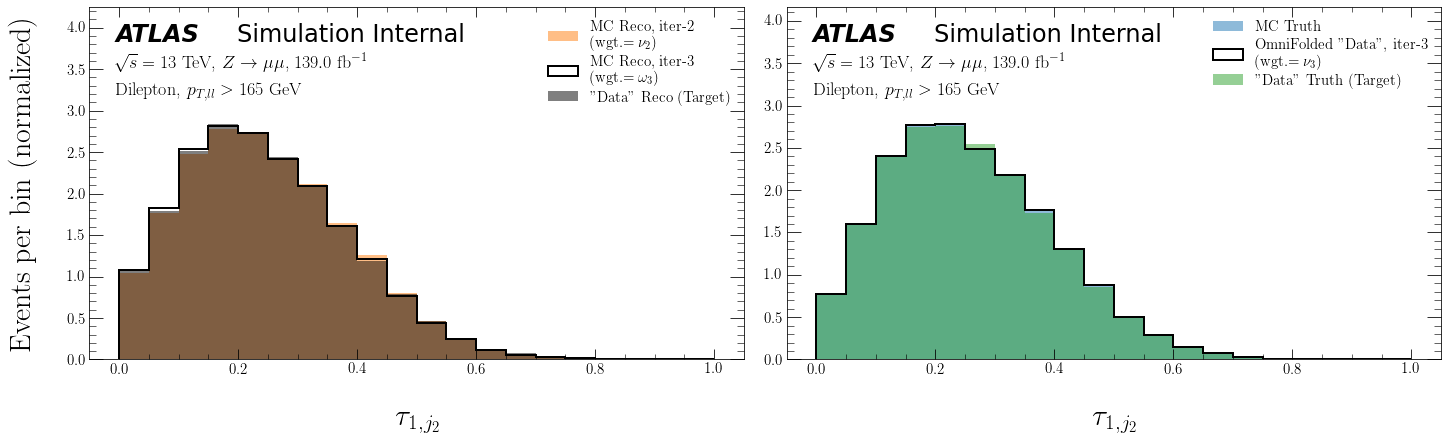

pT_trackj1 Results

ITERATION 1:


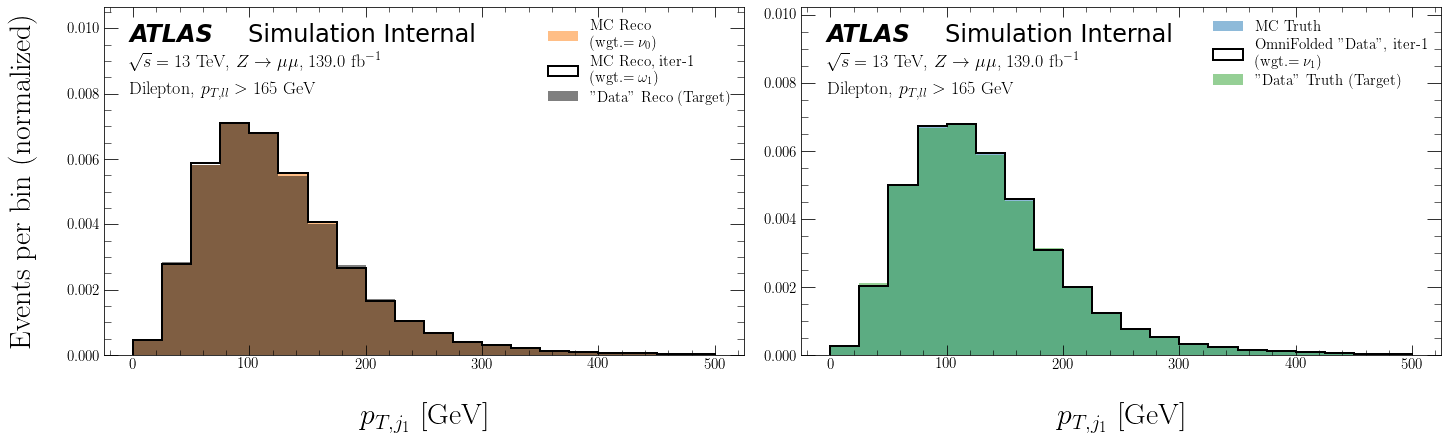

ITERATION 2:


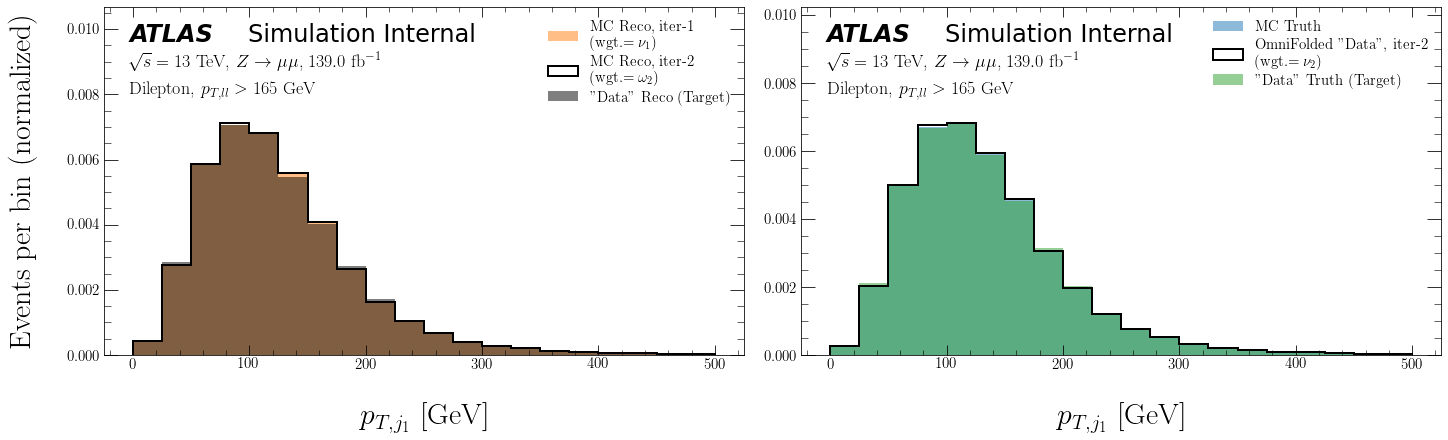

ITERATION 3:


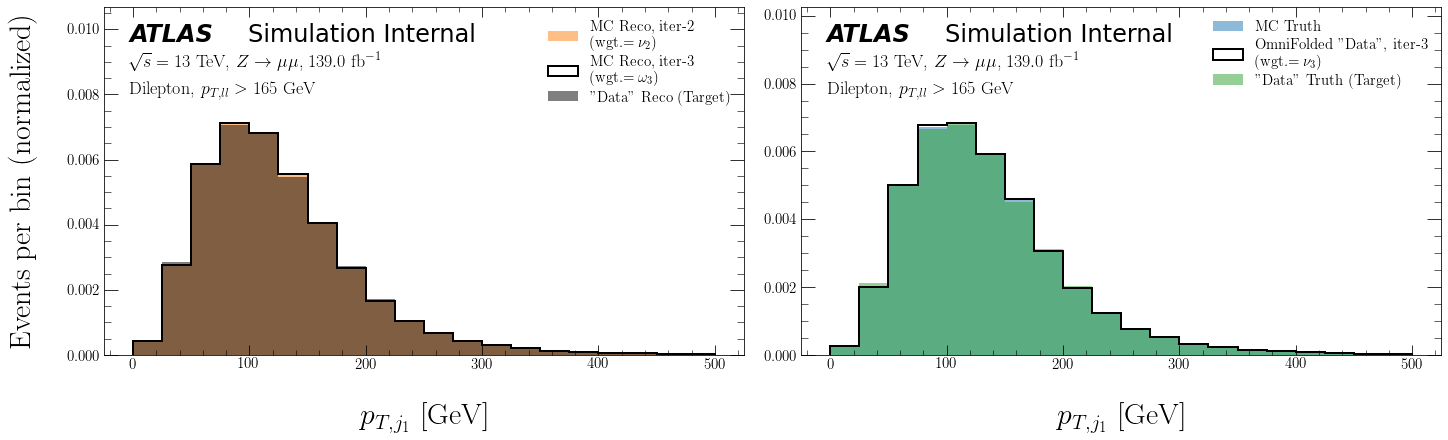

pT_trackj2 Results

ITERATION 1:


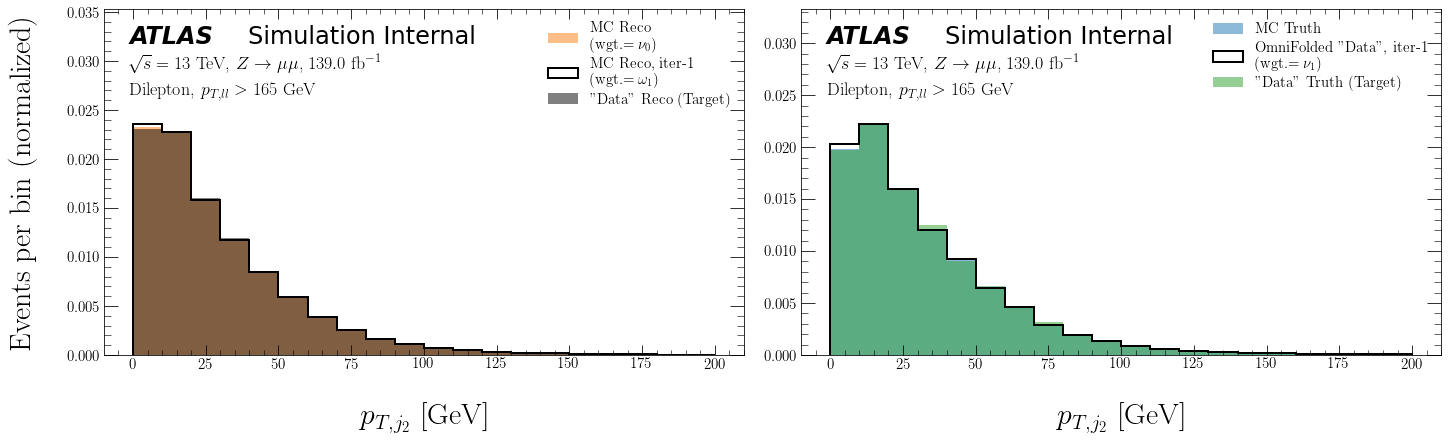

ITERATION 2:


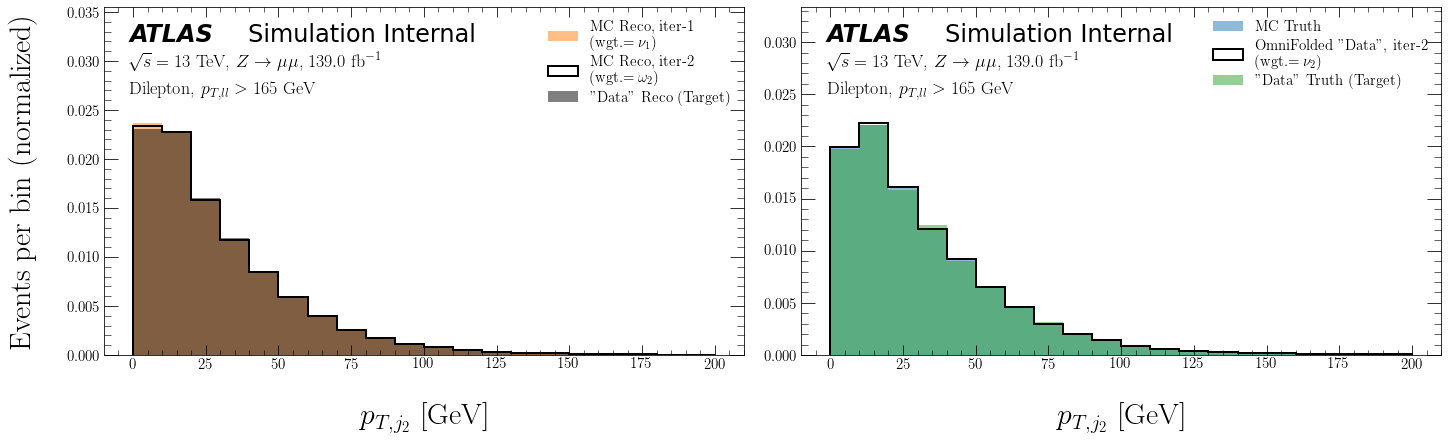

ITERATION 3:


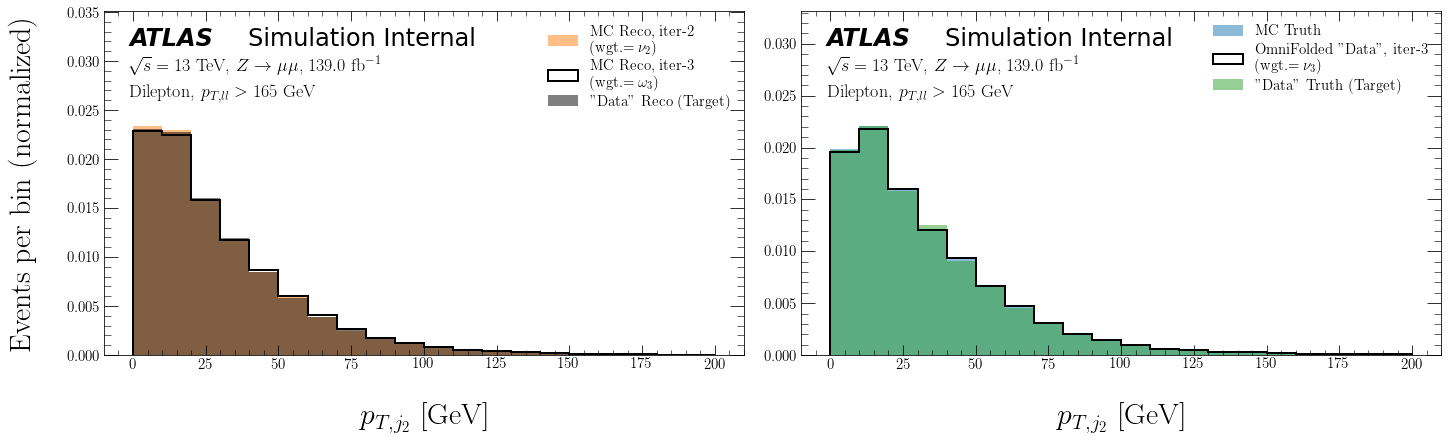

tau2_trackj1 Results

ITERATION 1:


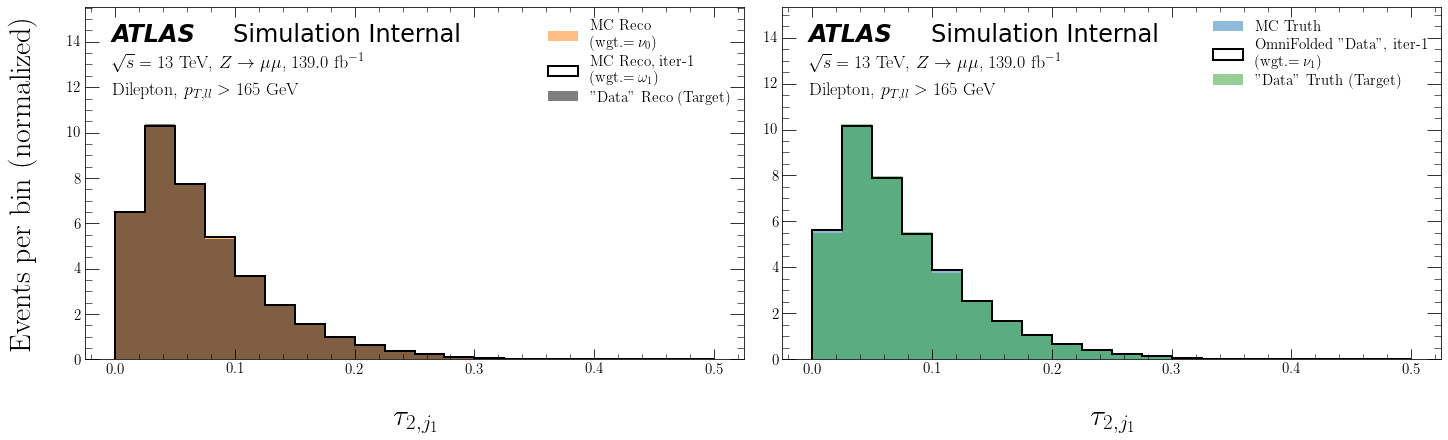

ITERATION 2:


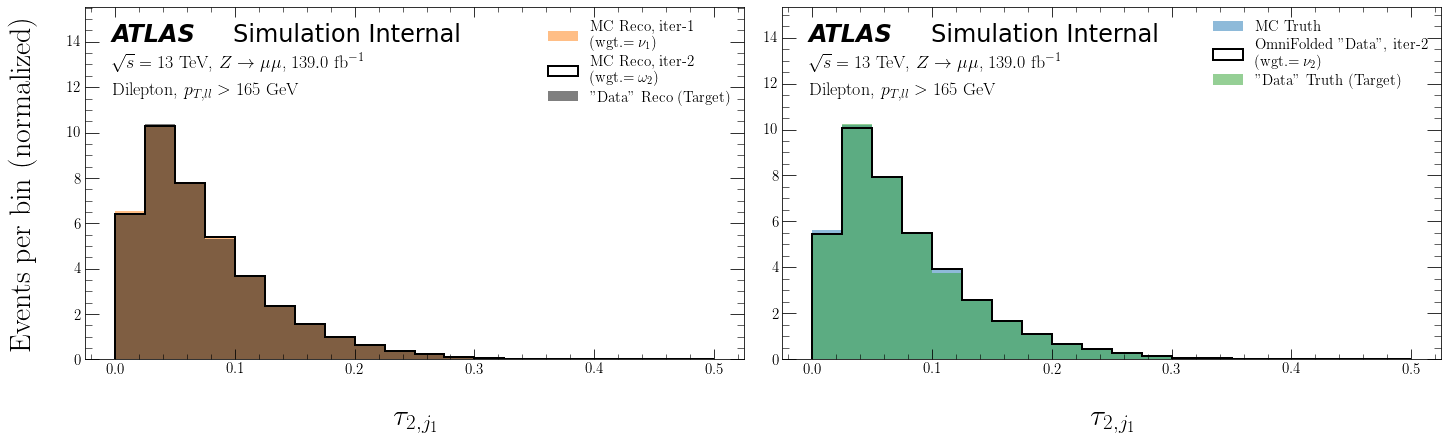

ITERATION 3:


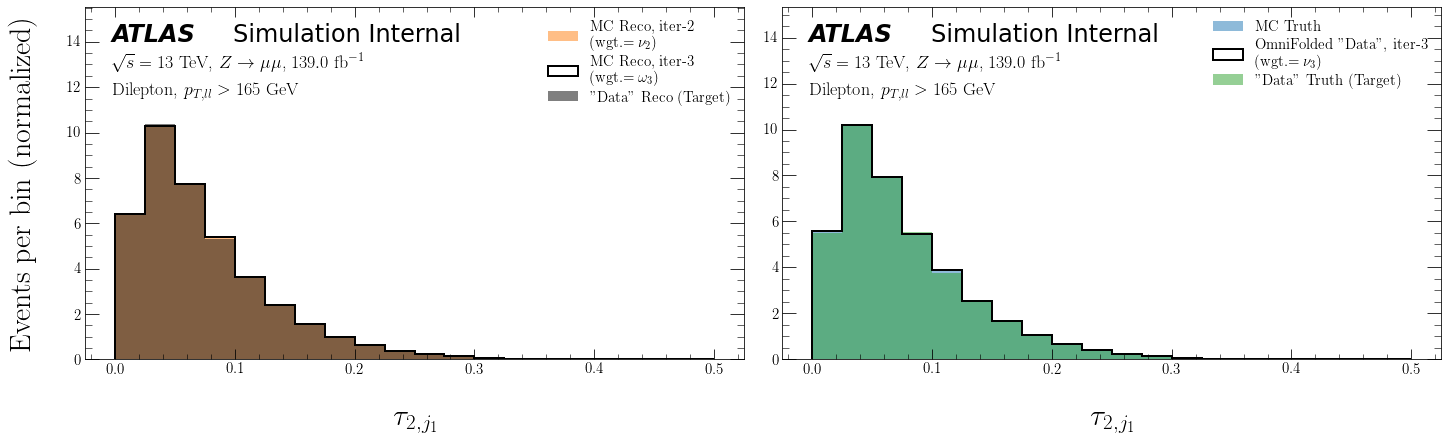

tau2_trackj2 Results

ITERATION 1:


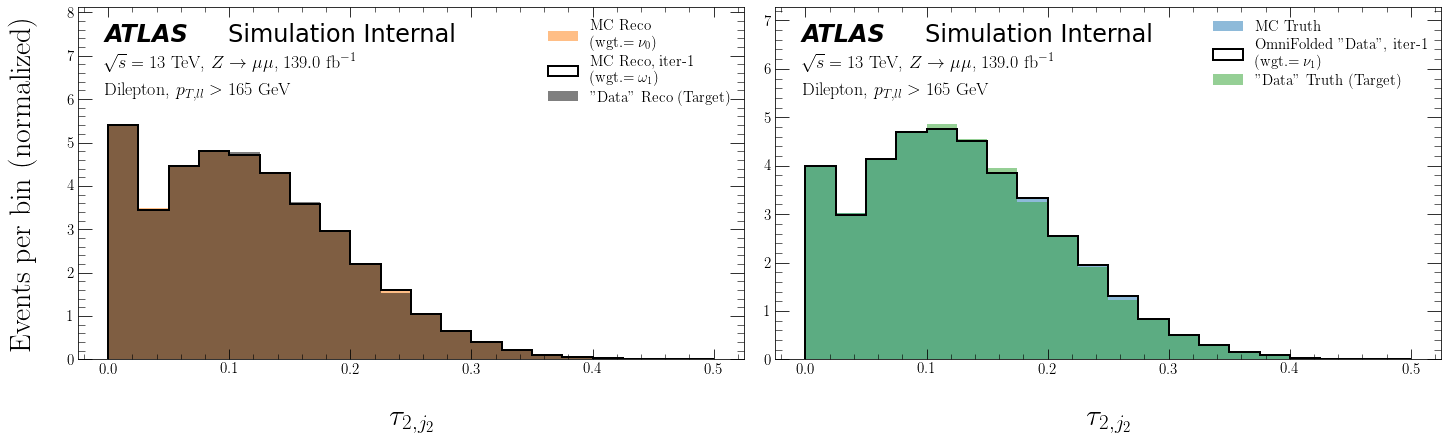

ITERATION 2:


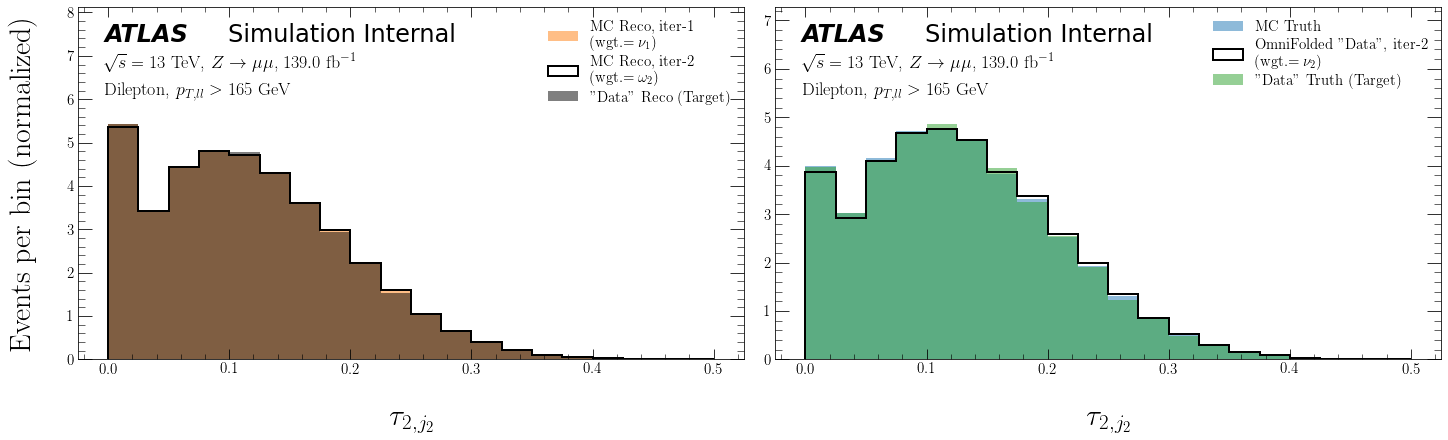

ITERATION 3:


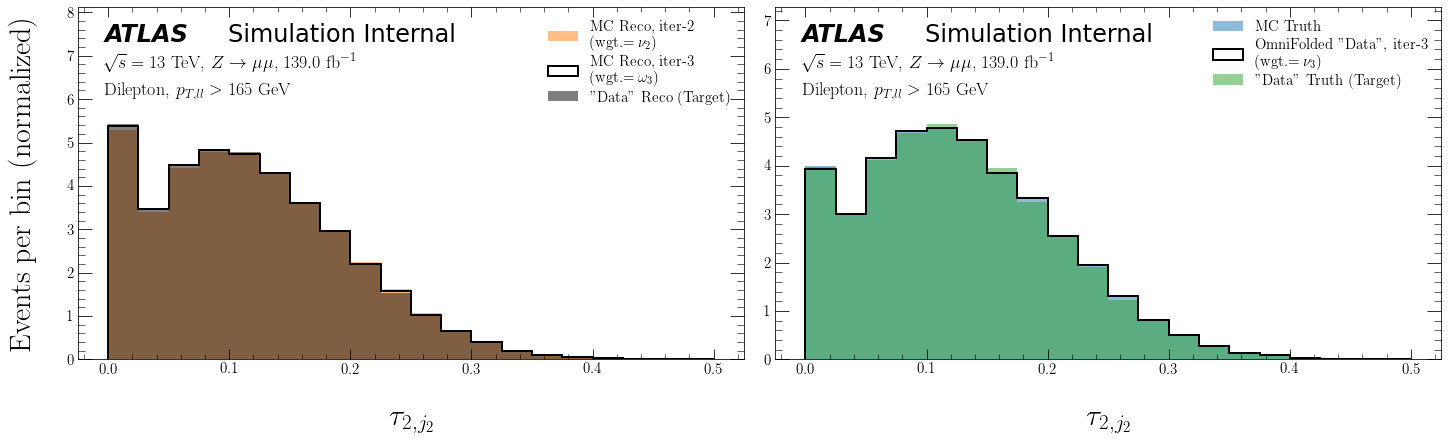

y_trackj1 Results

ITERATION 1:


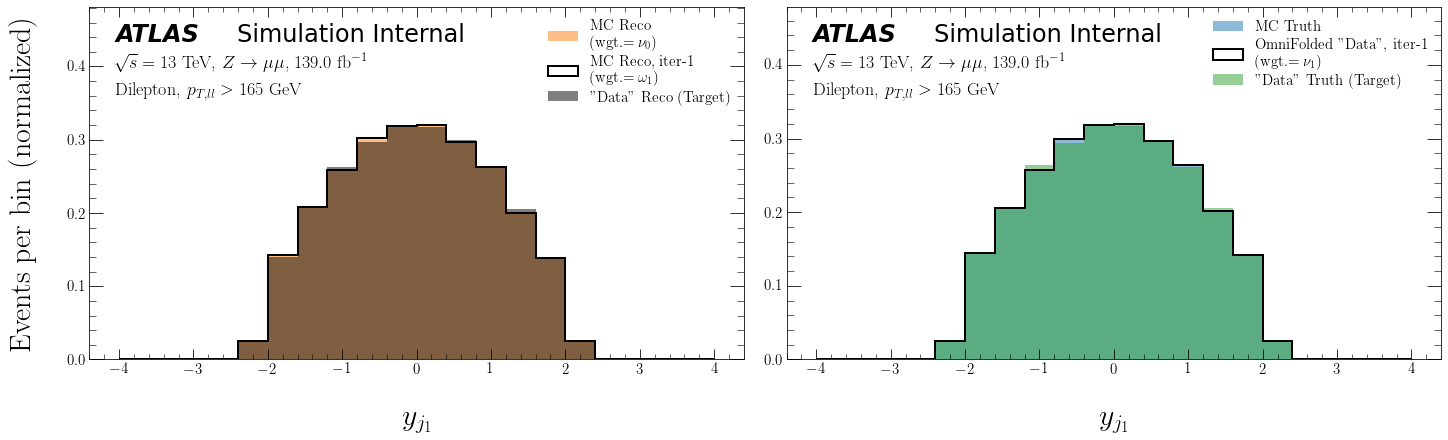

ITERATION 2:


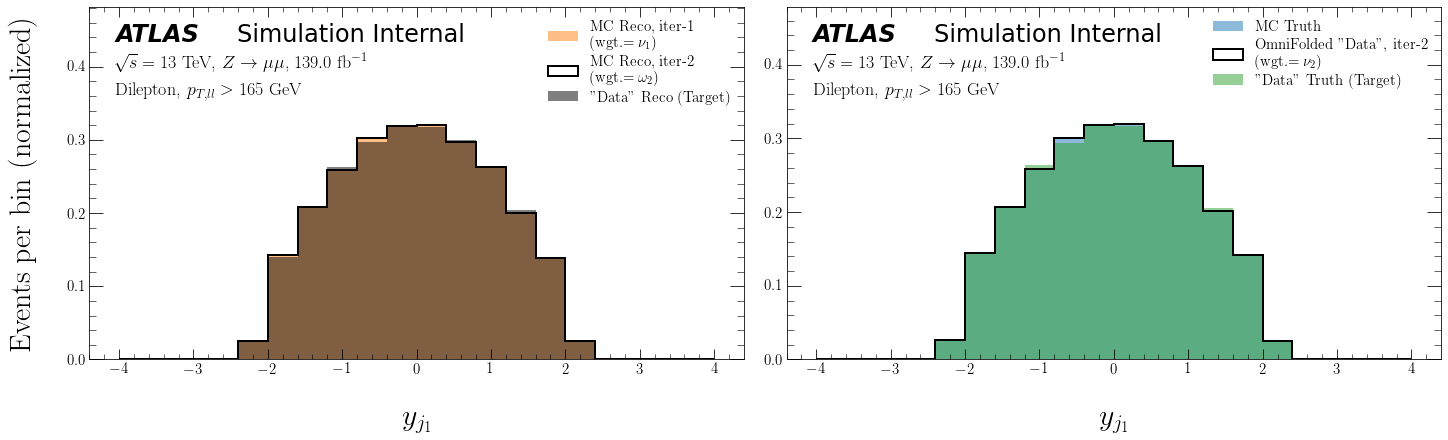

ITERATION 3:


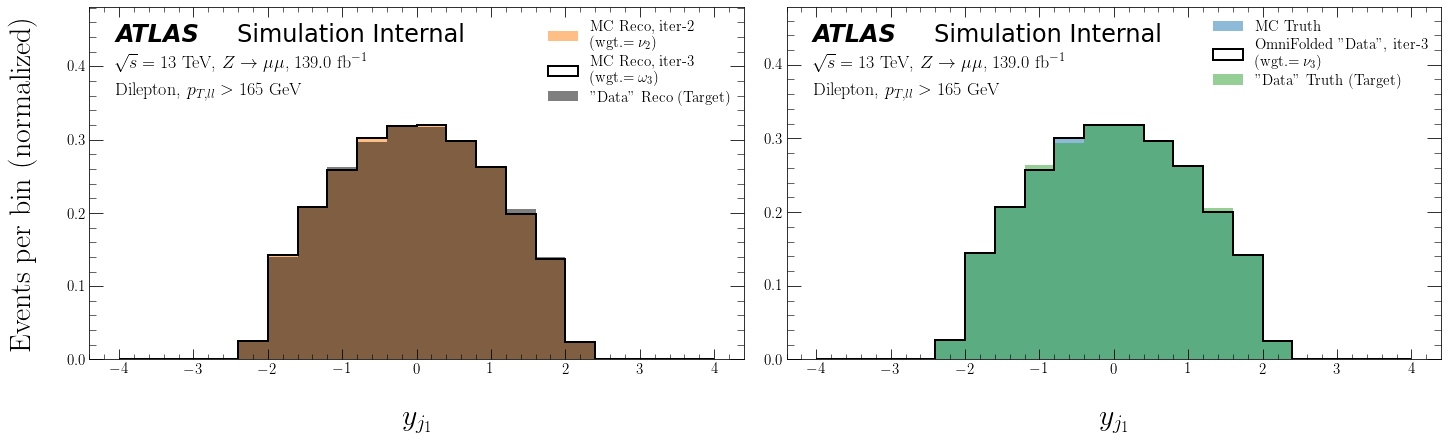

y_trackj2 Results

ITERATION 1:


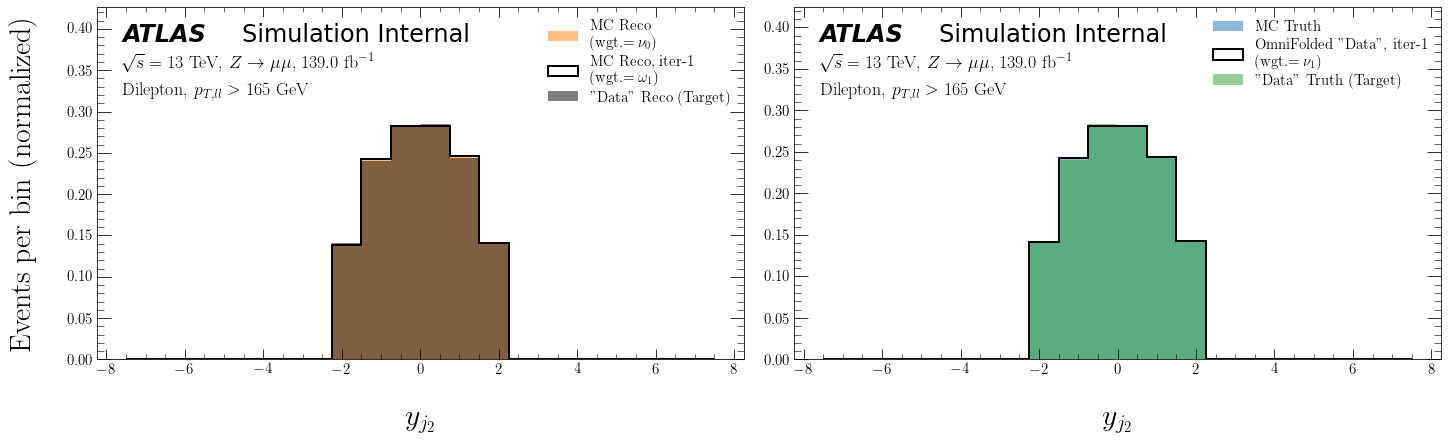

ITERATION 2:


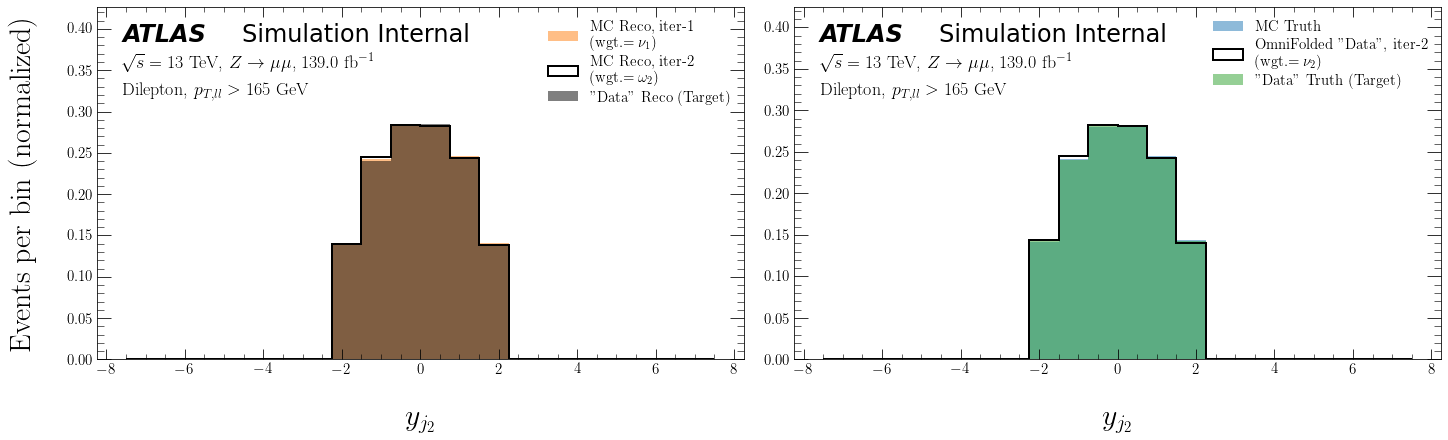

ITERATION 3:


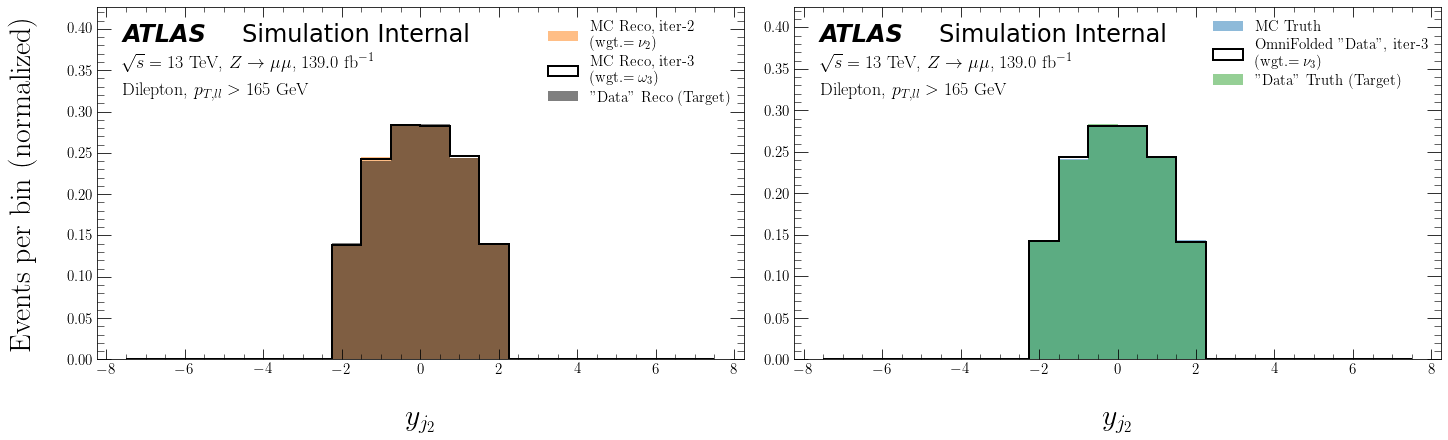

tau3_trackj1 Results

ITERATION 1:


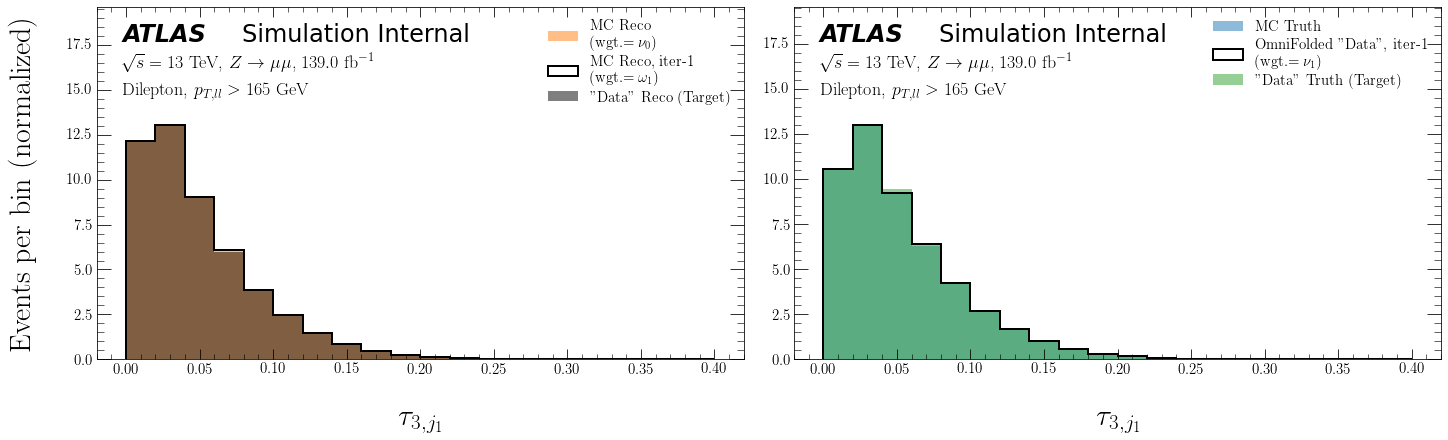

ITERATION 2:


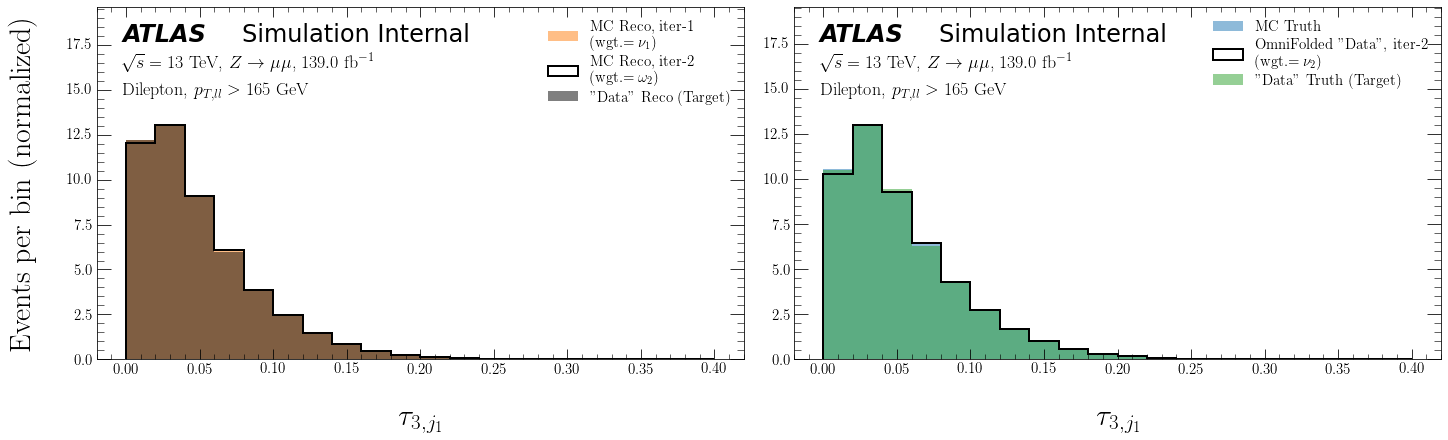

ITERATION 3:


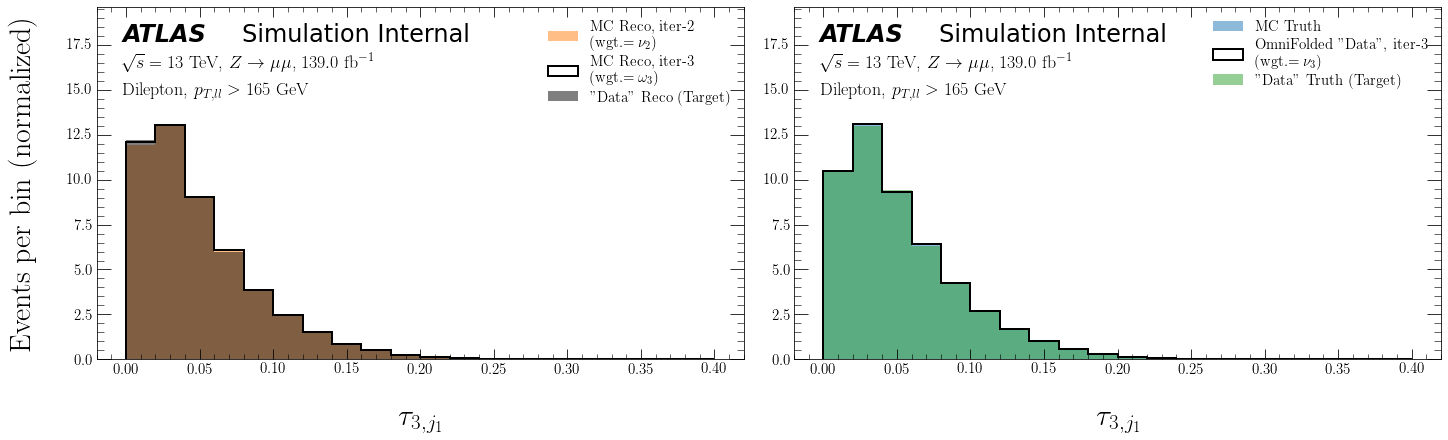

tau3_trackj2 Results

ITERATION 1:


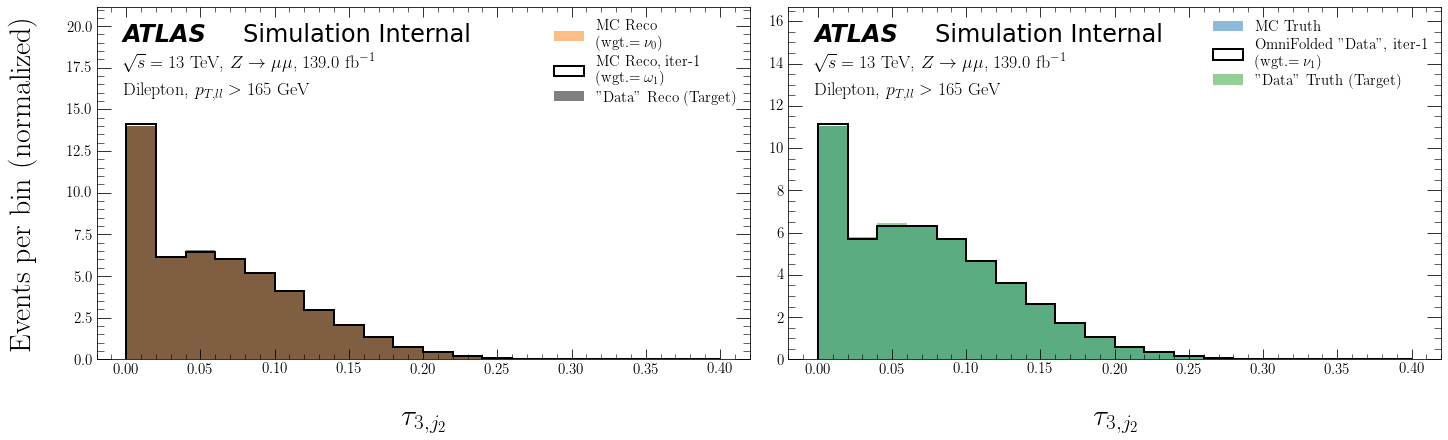

ITERATION 2:


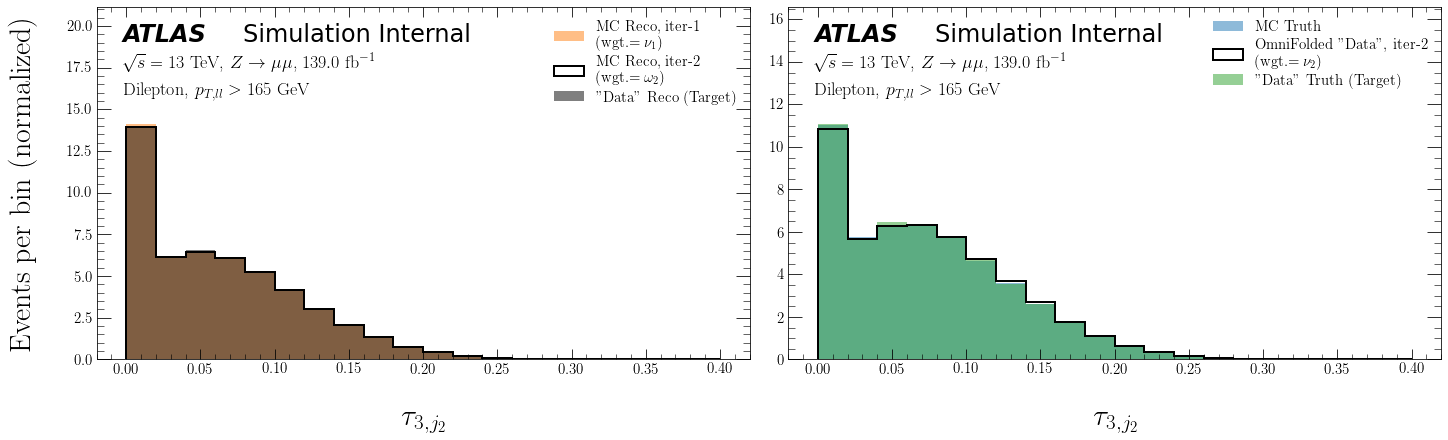

ITERATION 3:


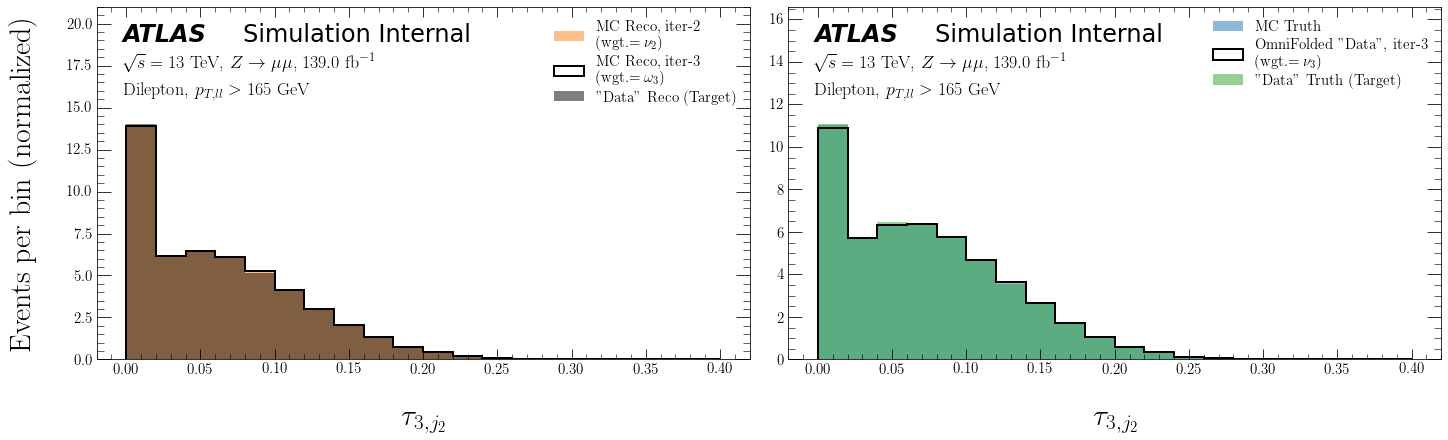

pT_ll Results

ITERATION 1:


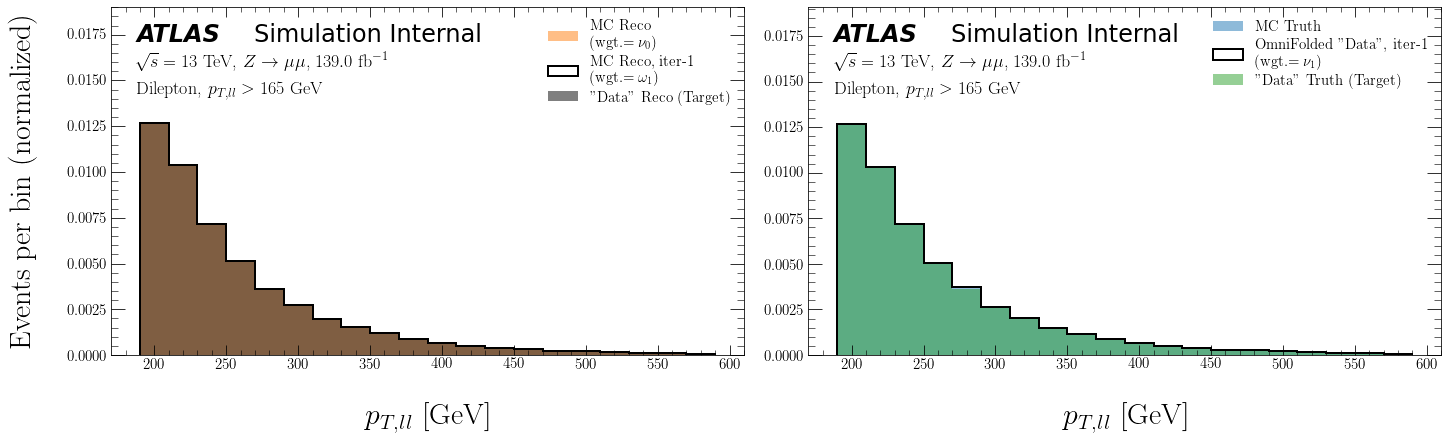

ITERATION 2:


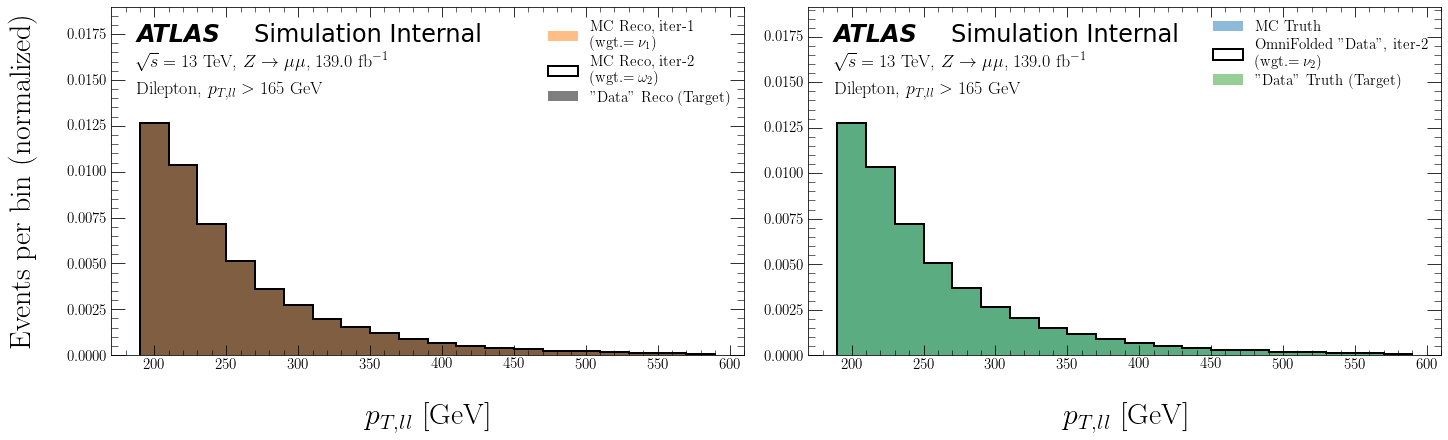

ITERATION 3:


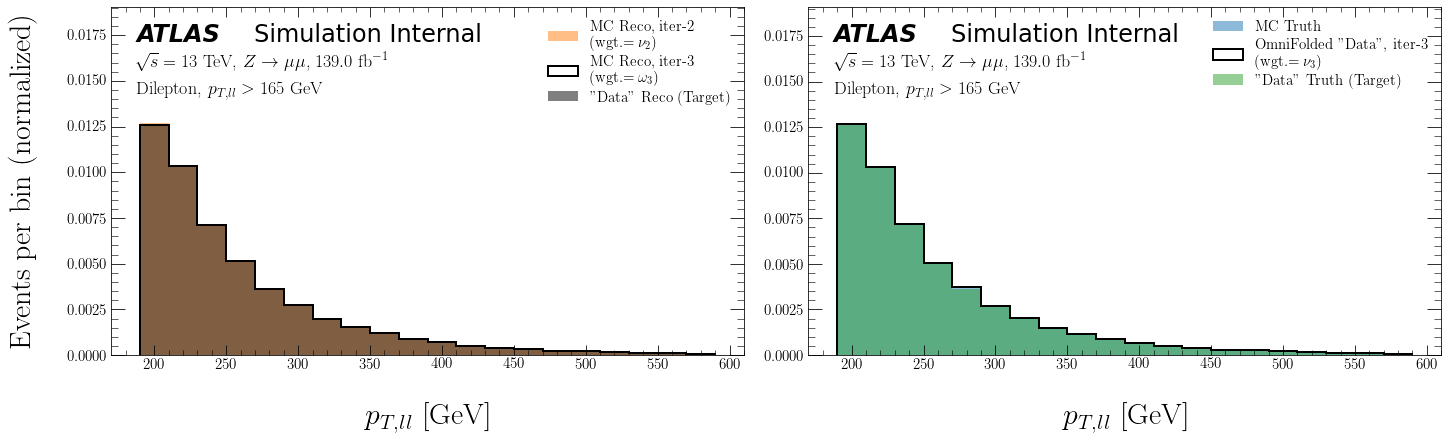

y_ll Results

ITERATION 1:


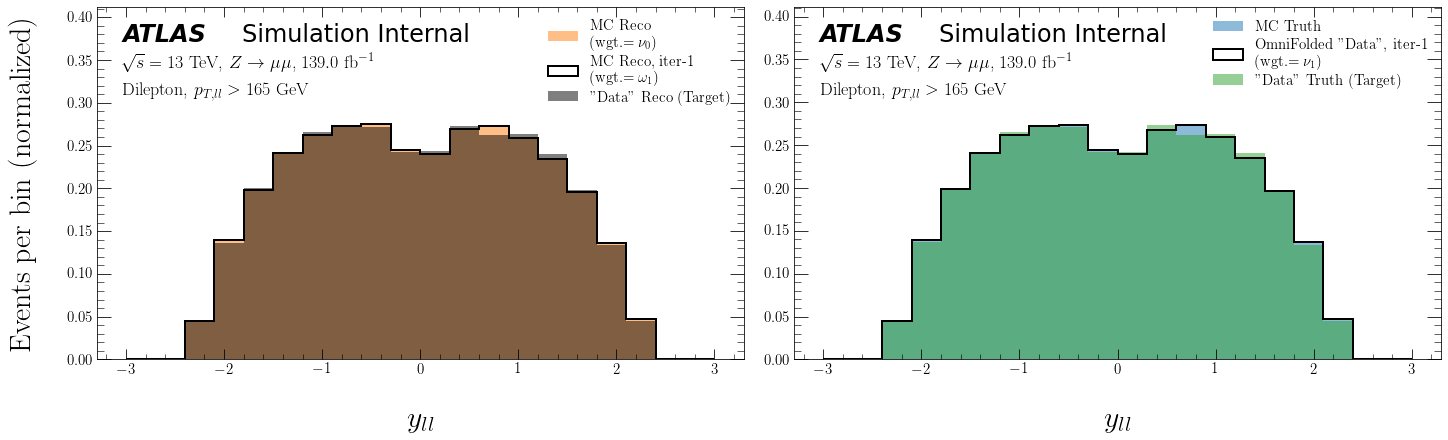

ITERATION 2:


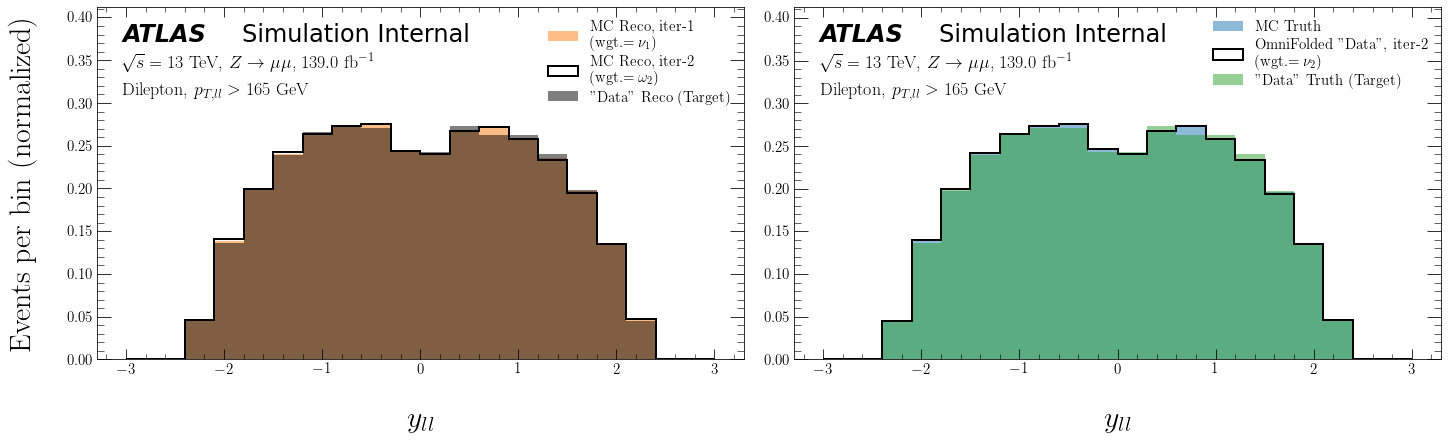

ITERATION 3:


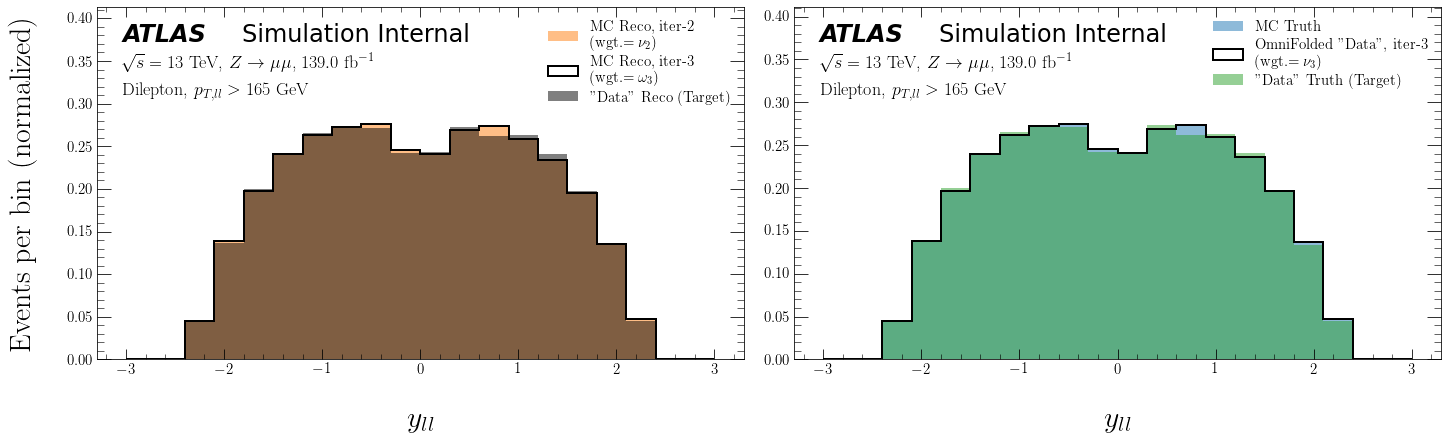

In [70]:
for i in range(len(obs)):
    print(obs[i]['file_label'] + " Results\n")
    bins = obs[i]['bins']
    x_label = obs[i]['plot_label']
    file_label = obs[i]['file_label']
    save_label = plot_dir + 'MultiFold/' + file_label + '/' + save_label0 + '-MultiFold-' + file_label

    plot_results(sim_truth=sim_truth[i],
                 sim_reco=sim_reco[i],
                 sim_weights_MC=sim_weights_MC,
                 data_truth=data_truth[i],
                 data_reco=data_reco[i],
                 data_weights_MC=data_weights_MC,
                 weights=weights,
                 bins=bins,
                 x_label=x_label,
                 save_label=save_label)